##Imports

In [151]:
!pip install thefuzz python-levenshtein

In [152]:
import pandas as pd
from thefuzz import fuzz
from itertools import combinations
import numpy as np
from collections import Counter
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re

# Exploratory Data Analysis (EDA):

## Text-Oriented Data Analysis

In [153]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]

file_path = 'Talent_Academy_Case_DT_2025.xlsx'
df = pd.read_excel(file_path)
display(df.head()), df.info(), display(df.describe().T), df.columns

,HastaNo,Yas,Cinsiyet,KanGrubu,Uyruk,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,Kadın,0 Rh+,Türkiye,"Becker Musküler Distrofisi, Hiportiroidizm, Ka...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",TOZ,Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5 Seans,Ayak Bileği,20 Dakika
1,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,20 Dakika
2,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika
3,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,Boyun,5 Dakika
4,145135,28,Erkek,0 Rh+,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",NaN,"Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15 Seans,"Boyun,Sırt",20 Dakika


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HastaNo          2235 non-null   int64 
 1   Yas              2235 non-null   int64 
 2   Cinsiyet         2066 non-null   object
 3   KanGrubu         1560 non-null   object
 4   Uyruk            2235 non-null   object
 5   KronikHastalik   1624 non-null   object
 6   Bolum            2224 non-null   object
 7   Alerji           1291 non-null   object
 8   Tanilar          2160 non-null   object
 9   TedaviAdi        2235 non-null   object
 10  TedaviSuresi     2235 non-null   object
 11  UygulamaYerleri  2014 non-null   object
 12  UygulamaSuresi   2235 non-null   object
dtypes: int64(2), object(11)
memory usage: 227.1+ KB


,count,mean,std,min,25%,50%,75%,max
HastaNo,2235.0,145333.100224,115.214248,145134.0,145235.0,145331.0,145432.0,145537.0
Yas,2235.0,47.327069,15.208634,2.0,38.0,46.0,56.0,92.0


(None,
 None,
 None,
 Index(['HastaNo', 'Yas', 'Cinsiyet', 'KanGrubu', 'Uyruk', 'KronikHastalik',
        'Bolum', 'Alerji', 'Tanilar', 'TedaviAdi', 'TedaviSuresi',
        'UygulamaYerleri', 'UygulamaSuresi'],
       dtype='object'))

In [154]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
  'missing values': missing_values,
  'missing values %': missing_percentage
}).sort_values(by='missing values %', ascending=False)
display(missing_info[missing_info['missing values'] > 0])

,missing values,missing values %
Alerji,944,42.237136
KanGrubu,675,30.201342
KronikHastalik,611,27.337808
UygulamaYerleri,221,9.888143
Cinsiyet,169,7.561521
Tanilar,75,3.355705
Bolum,11,0.492170


In [155]:
#creating a comprehensive function to easily track the latest status of the data during data cleaning and processing.
def generate_comprehensive_report(df):
    print(f"rows x cols: {df.shape}")
    print(f"Total cells: {df.size}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    print("Column types:")
    print(df.dtypes)

    print("\n missing")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent
    }).sort_values(by='Missing Count', ascending=False)
    print(missing_info[missing_info['Missing Count'] > 0])

    num_cols = df.select_dtypes(include=np.number).columns
    print(df[num_cols].describe().T)

    print("\n category")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    complex_cols = ['Tanilar', 'TedaviAdi', 'KronikHastalik', 'Alerji', 'UygulamaYerleri']
    simple_cols = [c for c in cat_cols if c not in complex_cols]

    for col in simple_cols:
        print(f"\nColumn: {col}")
        counts = df[col].value_counts()
        print(f"Unique values: {len(counts)}")
        print(counts.head(10))

    def analyze_split_column(df, col, top_n=10):
        print(f"\nColumn: {col}")
        items = df[col].dropna().str.split(',').explode().str.strip()
        items = items[items != '']
        if items.empty:
            print("No valid data.")
            return
        counts = Counter(items)
        print(f"Unique items: {len(counts)}")
        for item, count in counts.most_common(top_n):
            print(f"{item:<30} | {count}")

    for col in complex_cols:
        if col in df.columns:
            analyze_split_column(df, col)

generate_comprehensive_report(df)

rows x cols: (2235, 13)
Total cells: 29055
Duplicated rows: 928
Column types:
HastaNo             int64
Yas                 int64
Cinsiyet           object
KanGrubu           object
Uyruk              object
KronikHastalik     object
Bolum              object
Alerji             object
Tanilar            object
TedaviAdi          object
TedaviSuresi       object
UygulamaYerleri    object
UygulamaSuresi     object
dtype: object

 missing
                 Missing Count  Missing %
Alerji                     944  42.237136
KanGrubu                   675  30.201342
KronikHastalik             611  27.337808
UygulamaYerleri            221   9.888143
Cinsiyet                   169   7.561521
Tanilar                     75   3.355705
Bolum                       11   0.492170
          count           mean         std       min       25%       50%  \
HastaNo  2235.0  145333.100224  115.214248  145134.0  145235.0  145331.0   
Yas      2235.0      47.327069   15.208634       2.0      38.0      46.0

## Visual-Oriented Data Analysis

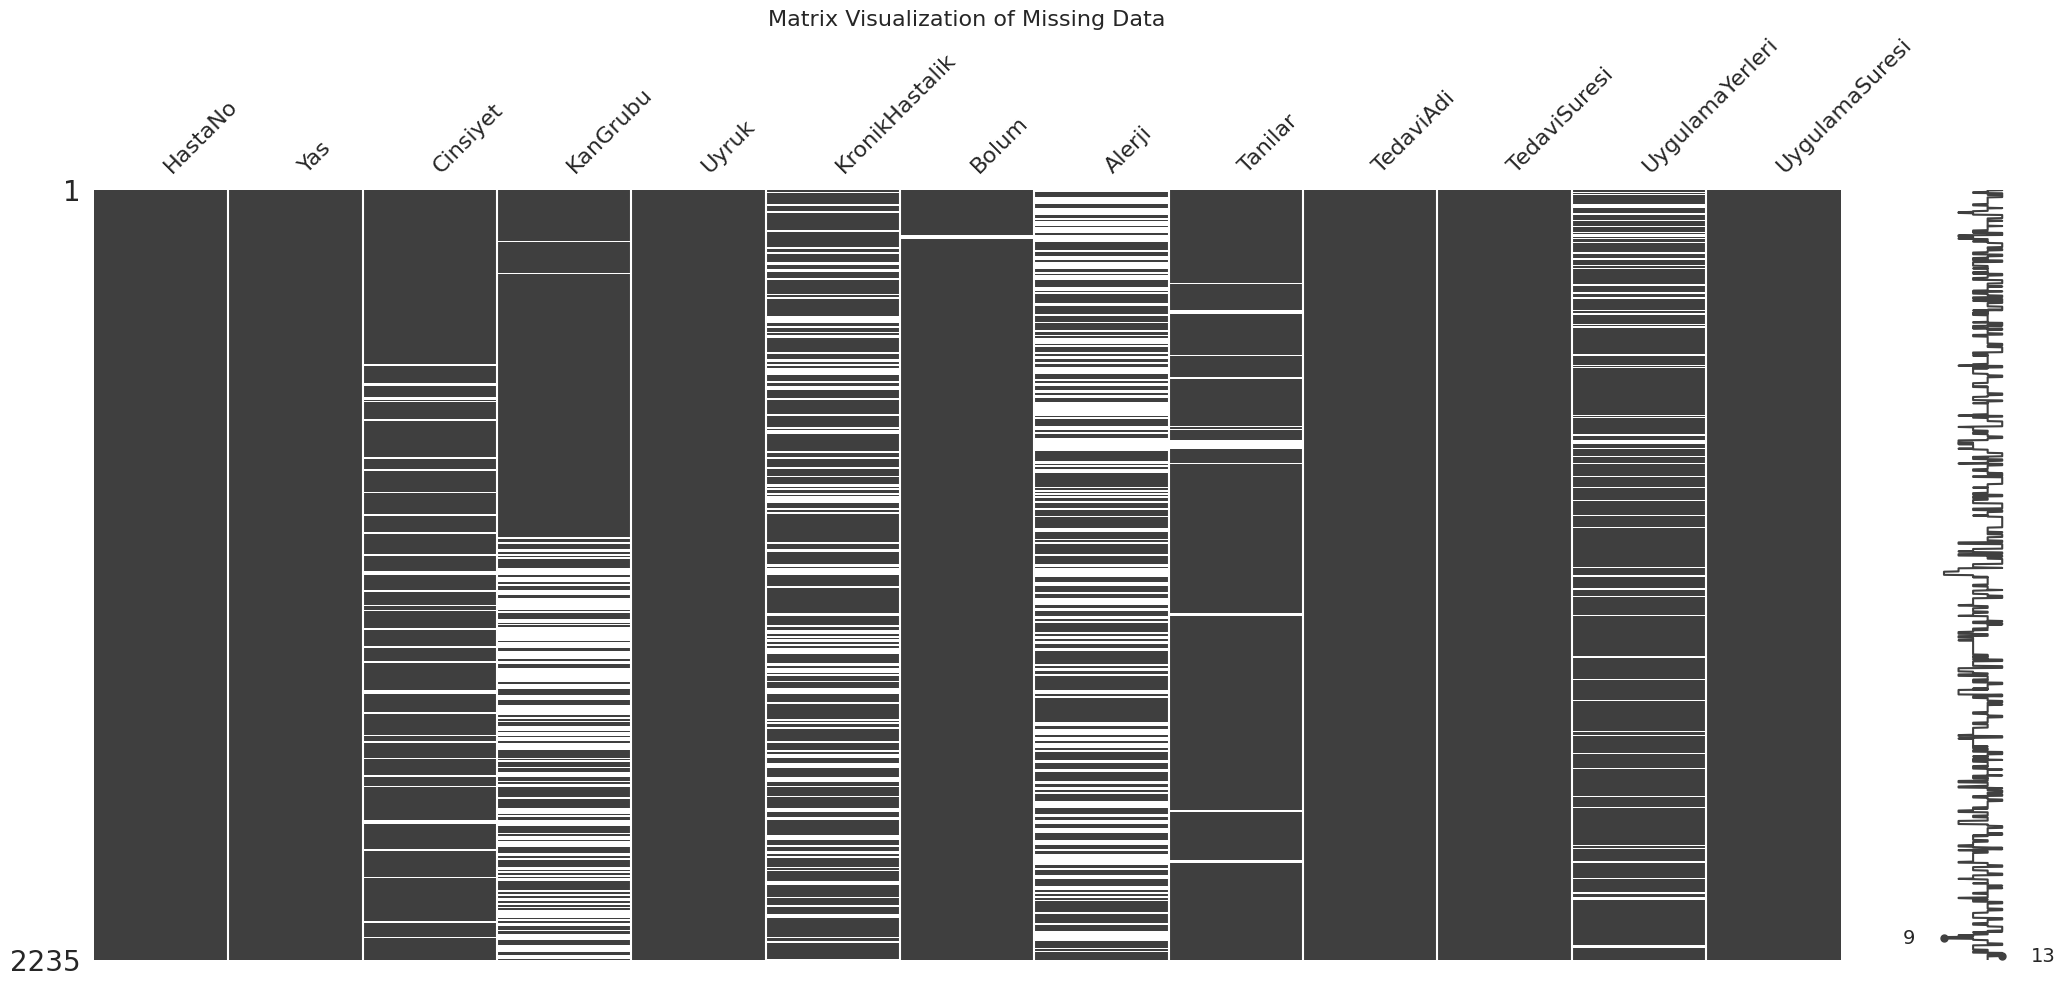

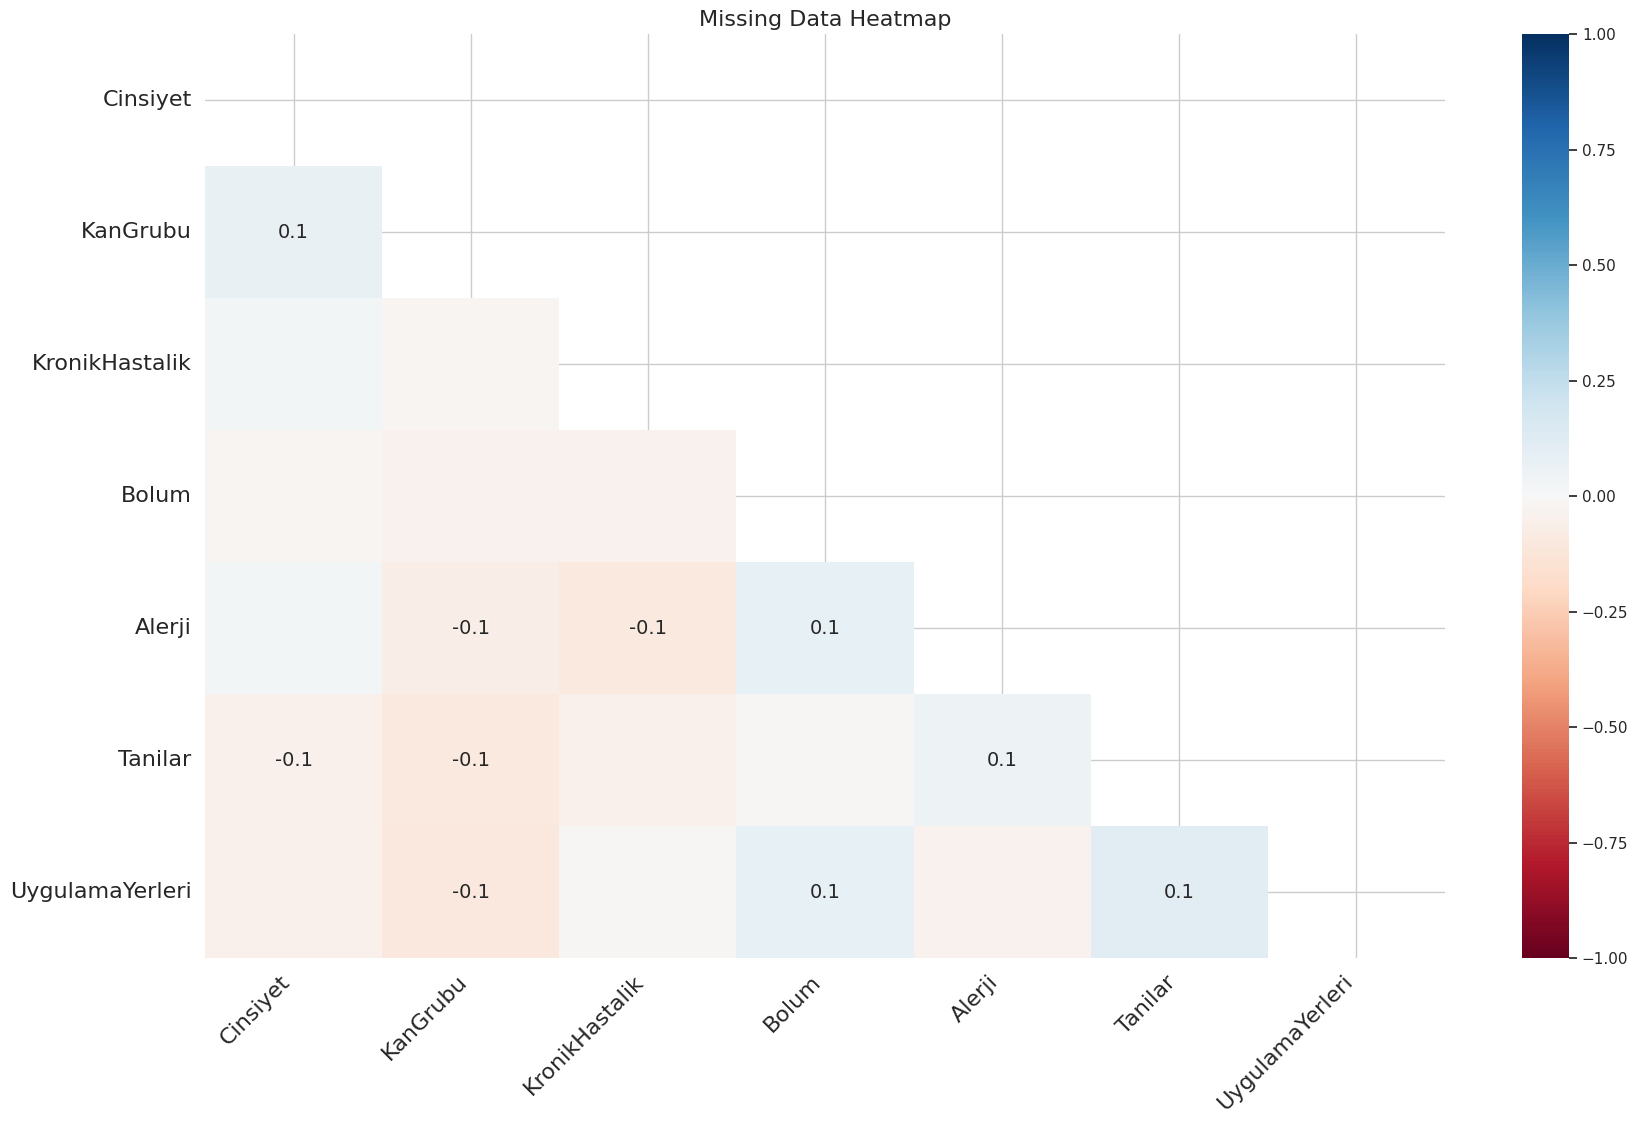

In [156]:
msno.matrix(df)
plt.title('Matrix Visualization of Missing Data', fontsize=16)
plt.show()
msno.heatmap(df)
plt.title('Missing Data Heatmap', fontsize=16)
plt.show()

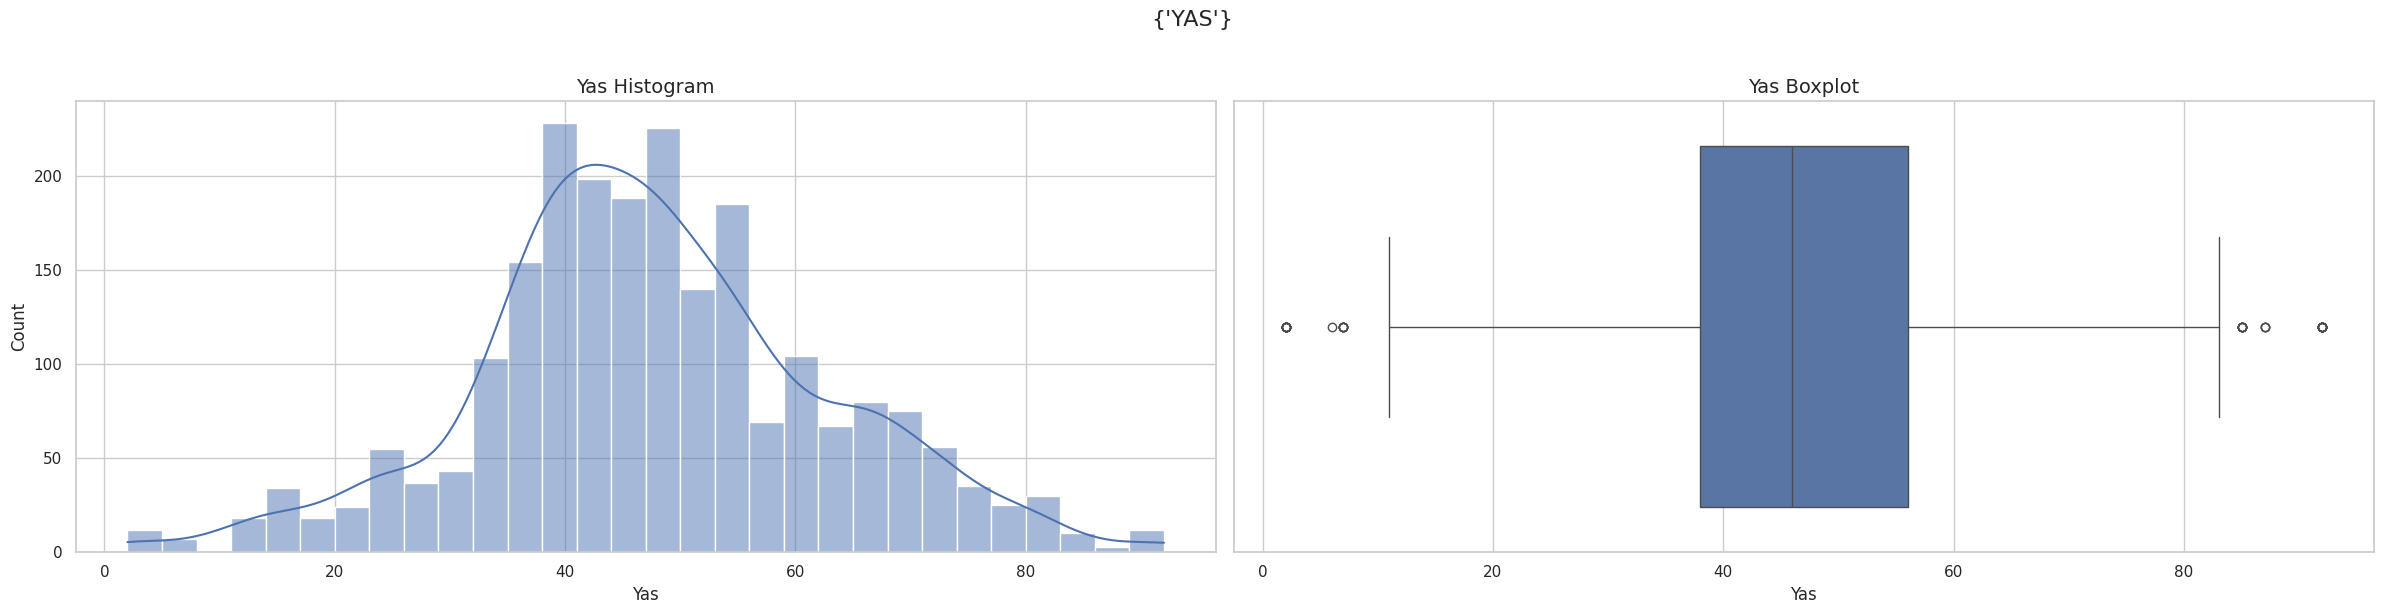

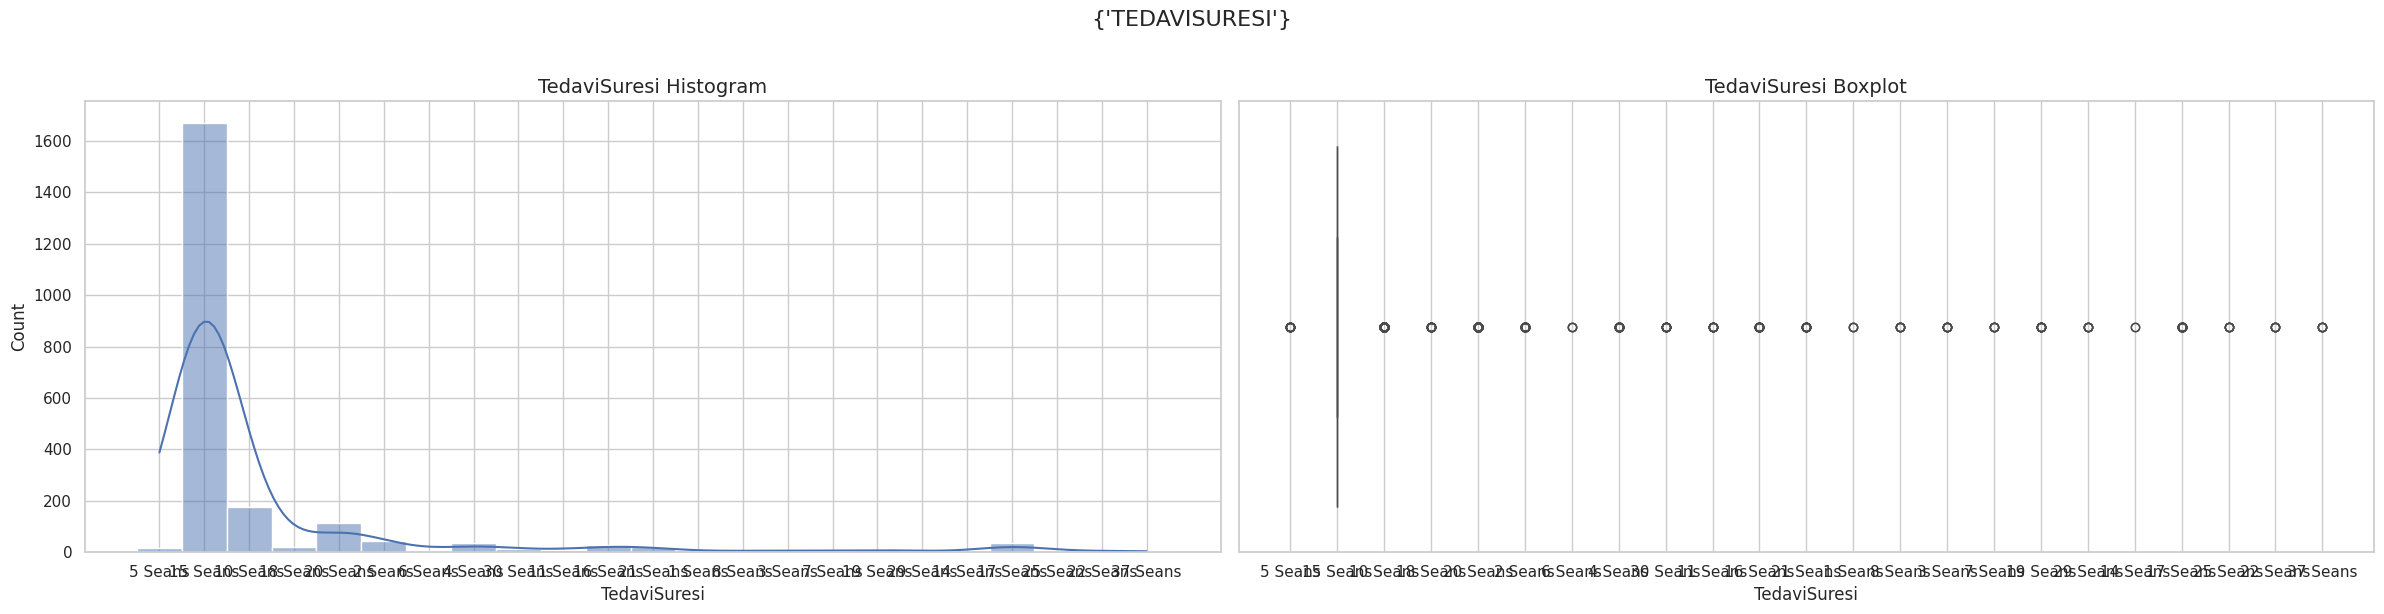

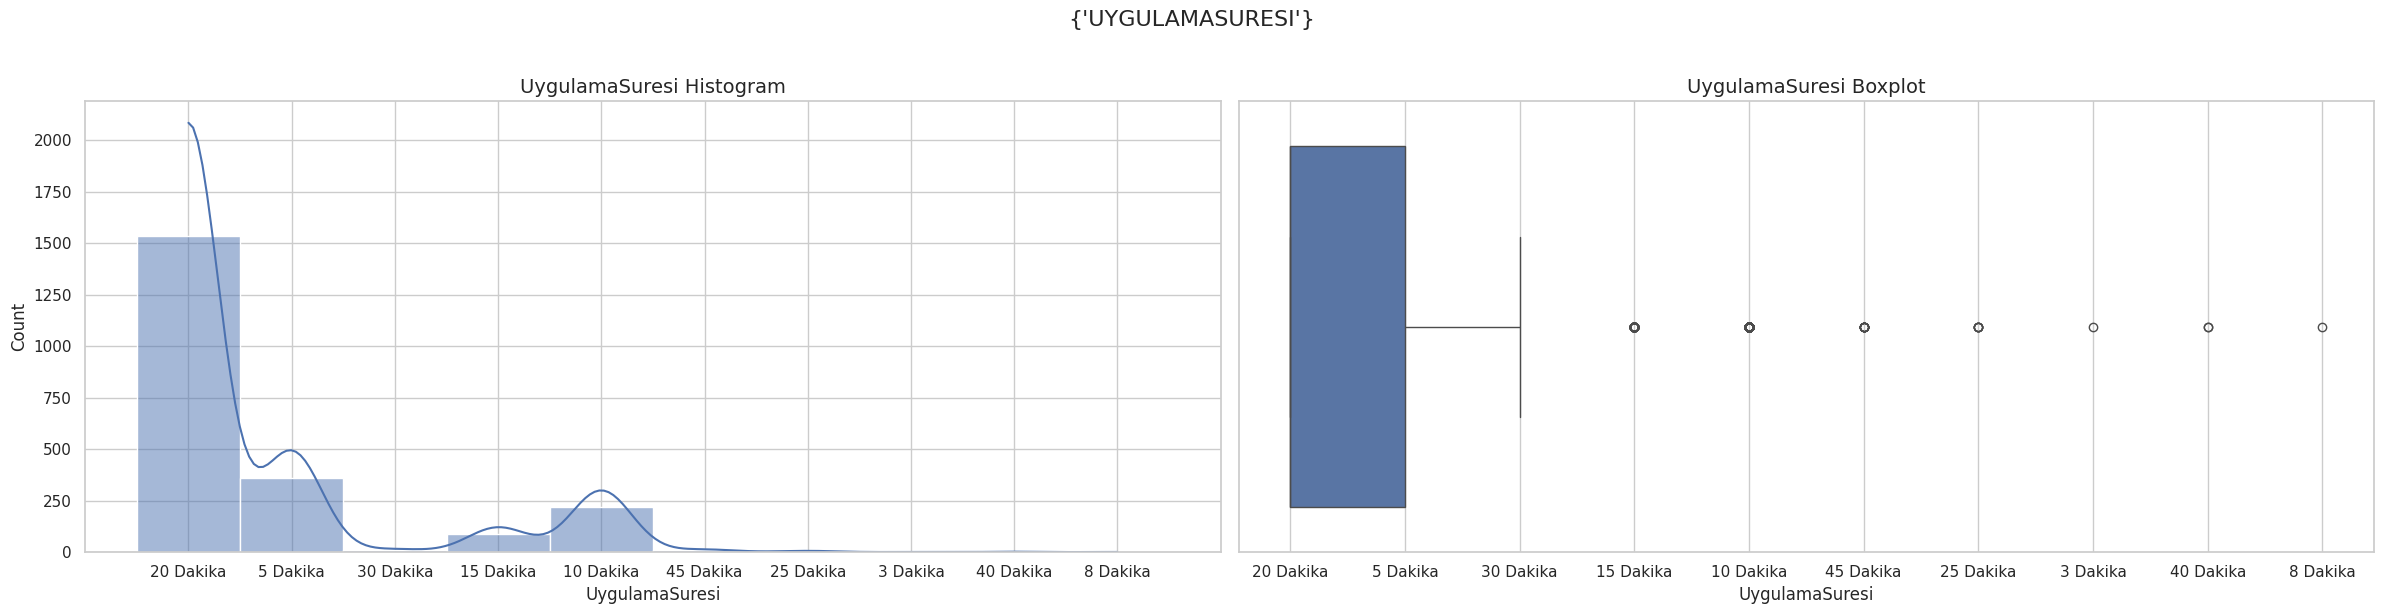

In [157]:
numerical_cols = ['Yas', 'TedaviSuresi', 'UygulamaSuresi']

for col in numerical_cols:
  plt.figure(figsize=(24, 6))
  # Histogram: Değişkenin dağılımını gösterir
  plt.subplot(1, 2, 1)
  sns.histplot(df[col], kde=True, bins=30)
  plt.title(f'{col} Histogram', fontsize=14)
  # Boxplot: Aykırı değerleri ve çeyrekleri gösterir
  plt.subplot(1, 2, 2)
  sns.boxplot(x=df[col])
  plt.title(f'{col} Boxplot', fontsize=14)
  plt.suptitle({col.upper()}, fontsize=16, y=1.02)
  plt.tight_layout()
  plt.show()

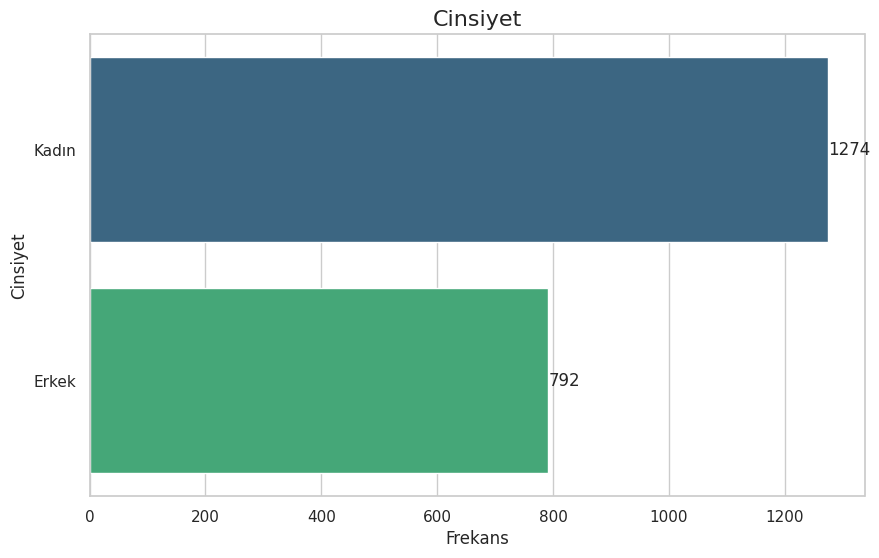

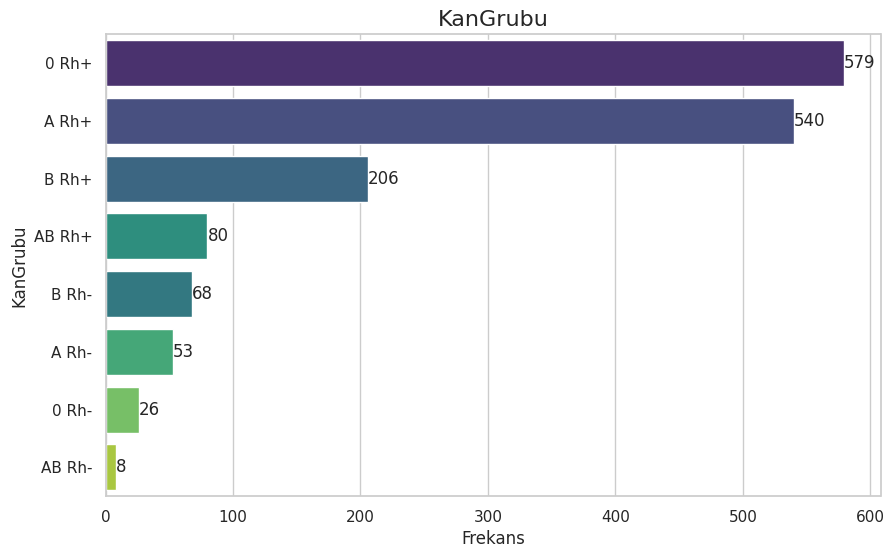

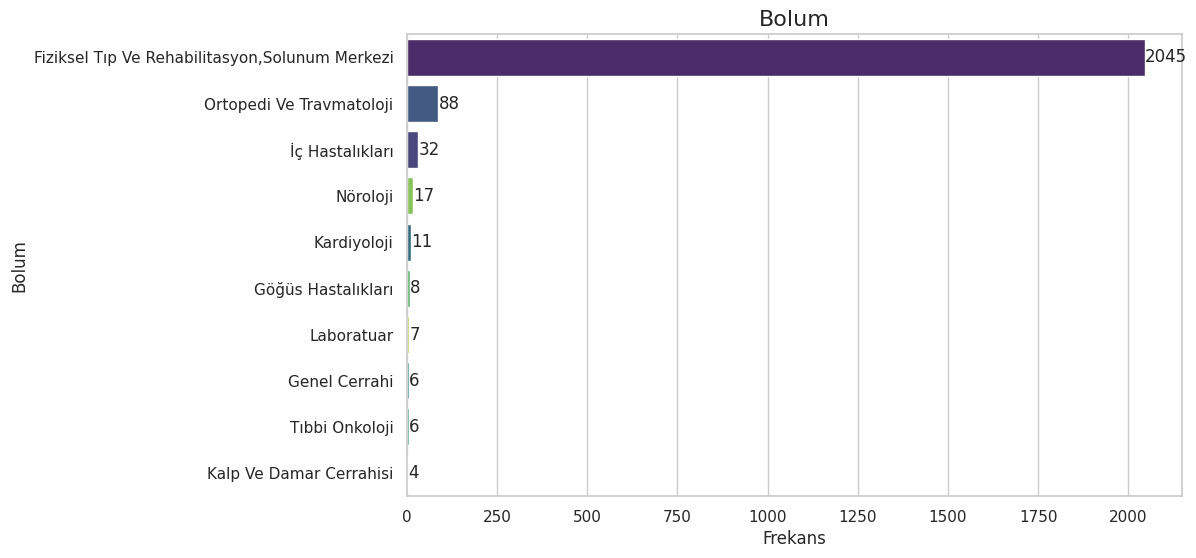

In [158]:
categorical_cols = ['Cinsiyet', 'KanGrubu', 'Bolum']

for col in categorical_cols:
  plt.figure(figsize=(10, 6))
  ax = sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis', hue=df[col], legend=False)
  plt.title(f'{col}', fontsize=16)
  plt.xlabel('Frekans', fontsize=12)
  plt.ylabel(col, fontsize=12)
  for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1, p.get_y() + p.get_height()/2.,
      f'{int(width)}',
      ha='left', va='center')

plt.show()

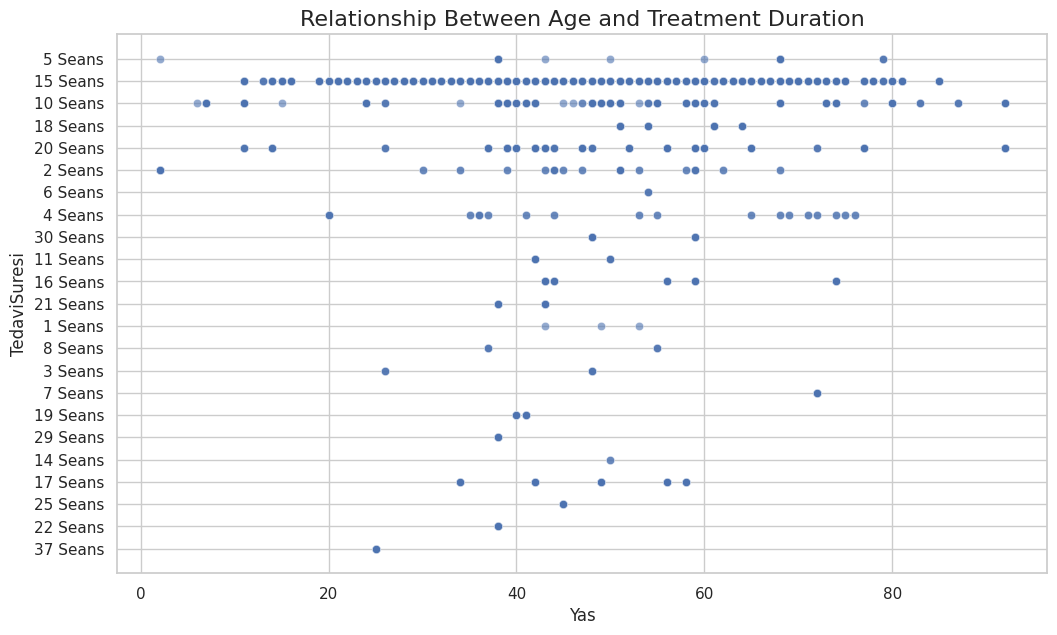

In [159]:
sns.scatterplot(data=df, x='Yas', y='TedaviSuresi', alpha=0.6)
plt.title('Relationship Between Age and Treatment Duration', fontsize=16)
plt.show()

## Findings
1. `HastaNo` gibi bir sonucu tahmin etmek için hiçbir anlamlı desen içermeyen, model için saf bir gürültü kaynağıdır. Bu nedenle modelin yanlış ezber yapmasını engellemek için **silinecek**.

2. `Uyruk` sütundaki verilerin neredeyse tamamını "Türkiye" oluşmaktadır. Modelin farklı sonuçları ayırt etmesine yardımcı olacak anlamlı bir çeşitlilik (varyans) sunmadığı için tahmin gücü yoktur ve gereksiz bir özelliktir **silinecek**.

3. **Çok kirli veri güzel bir temizliği ihtiyaç var** `Alerji` sütununda `Polen` ve `POLEN` şeklinde aynı bilgi 2 farklı şekilde yazılmış. `Toz`, `TOZ` ve `Toz,TOZ` değerleri var belli satırlarda. Diğer sütunlardada yazım farklılıkları, yazım hataları, farklı ek kullanımı(kolla ve kol ile gibi) ve gerkesiz numaralandırmalar oldukça fazla.

4. Hedef veri olan `TedaviSuresi` sütununda 15 seans oranı çok fazla (+1500).
 `KisaSureliTedavi`, `OrtaSureliTedavi`, `UzunSureliTedavi` gibi kategorilere ayrılabilir.  

5. `Bolum` sütununda `Fiziksel Tıp Ve Rehabilitasyon` oranı aşırı fazla(+2000) ama kıymetli bir veri olduğu için silmek yerine çok nadir görünen bölümleri (örneğin, toplamda 5'ten az görünenler) "Diğer_Bolumler" adında tek bir kategori altında toplanabilir. Bu, kategorik değişkenin karmaşıklığını (cardinality) azaltır ve modelin daha iyi genelleme yapmasına yardımcı olur.

6. `UygulamaSuresi` sütununda verilerin büyük kısmı(+1500) "20 Dakika" değerine sahip. Bu durumun diğer verilerle ilişkisini daha iyi anlamak için `UygulamaSuresi` 20 dk mı değil mi(1-0) sütünu oluşturulabilir.

7. **Tamamen aynı veriler kopyalanarak çoğaltılmış.** `HastaNo`'dan `UygulamaYerleri`'ne kadar tüm veriler birebir aynı. Mesela veriden 4 adet oluşturulmuş 4 veriden 1'inin UygulamaSuresi verisi değiştirilmiş.
Bunlar  UygulamaSuresi ortalması alınarak birleştirilecek.

8. Bu kopya veriler eksik verileri doldurmkata işe yarar gözüküyor
Örnek: Aynı `HastaNo` ama `KanGrubu`, `KronikHastalık`, `Cinsiyet`, `Alerji` gibi verileri bir satırda var diğerinde yok.

9. `TedaviAdi` verisi oldukça fazla `UygulamaYerleri` verisi içeriyor kendi içinde. Bu hem `UygulamaYerleri` verisini doldurmak için bir fırsta hem de `TedaviAdi` verisi için gerksiz bir gürültü. Aynı şekilde `Tani` veriside bolca `UygulamaYerleri` verisi içersede bazı durumlarda baş ağrısının Uygulama yeri sırt olaibliryor. Bu nedenle en sağlıklısı `TedaviAdi`-> `UygulamaYerleri` veri doldurma.

**Not:** Burada tespitler doğru ama düşünülen çözümlerin bazıları ilerleyen aşamada daha detaylı incelemelerle değişecektir.

**Eksikler**
1. `Alerji`: %42(944)

2. `KanGrubu`: %30(675)

3. `KronikHastalık`: %27(611)

4. `UygulamaYerleri`: %10(221)

5. `Cinsiyet`: %7(169)

6. `Tanılar`: %3(75)

# Data Processing

## Cleaning

In [160]:
df.drop(columns='Uyruk', inplace=True)

In [161]:
columns_to_clean = [
    'Cinsiyet', 'KanGrubu', 'KronikHastalik', 'Bolum',
    'Alerji', 'Tanilar', 'TedaviAdi', 'TedaviSuresi',
    'UygulamaYerleri', 'UygulamaSuresi'
]
# 'i̇'
def turkish_lower(text):
    if not isinstance(text, str):
        return text
    text = text.replace('I', 'ı')
    text = text.replace('İ', 'i')
    text = text.lower()
    return text

for col in columns_to_clean:
  if df[col].dtype == 'object':
     df[col] = df[col].str.strip()
     df[col] = df[col].apply(turkish_lower)


def advanced_text_cleaner(text):

    if not isinstance(text, str):
        return text

    garbage_pattern = r'[\u200b\u200c\u200d\ufeff\xad`´\'\"]|_x000d_'
    cleaned_text = re.sub(garbage_pattern, '', text)
    # çoklu boşluklar
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

columns_for_regex_cleaning = [
    'KronikHastalik', 'Bolum', 'Alerji', 'Tanilar',
    'TedaviAdi', 'UygulamaYerleri'
]
for col in columns_for_regex_cleaning:
  if col in df.columns:
    df[col] = df[col].apply(advanced_text_cleaner)


output_file = 'Talent_Clean.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Temizlik işlemi tamamlandı.")

Temizlik işlemi tamamlandı.


In [162]:
df['TedaviSuresi'] = df['TedaviSuresi'].str.replace(' seans', '', regex=False).str.strip()
df['UygulamaSuresi'] = df['UygulamaSuresi'].str.replace(' dakika', '', regex=False).str.strip()
df['TedaviSuresi'] = pd.to_numeric(df['TedaviSuresi'], errors='coerce')
df['UygulamaSuresi'] = pd.to_numeric(df['UygulamaSuresi'], errors='coerce')
df.to_csv('Talent_Clean.csv', index=False)
print("dakika ve seans yazıları silindi sütunlar sayısal değere dönüştürüldü.")

dakika ve seans yazıları silindi sütunlar sayısal değere dönüştürüldü.


In [163]:
def find_similar_strings(dataframe, column_name, threshold=85):

    print(f"\n'{column_name}' Text Similarity Analysis")

    series = dataframe[column_name].dropna().astype(str).str.split(',').explode()
    unique_values = series.str.strip().unique()

    groups = defaultdict(list)

    processed = set()

    for value in unique_values:
        if value in processed:
            continue

        current_group = [value]
        processed.add(value)

        for other_value in unique_values:
            if other_value in processed:
                continue

            ratio = fuzz.ratio(value.lower(), other_value.lower())

            if ratio >= threshold:
                current_group.append(other_value)
                processed.add(other_value)

        if len(current_group) > 1:
            print(f"Potansiyel Grup Bulundu: {current_group}")

find_similar_strings(df, 'Alerji', threshold=85)
find_similar_strings(df, 'Tanilar', threshold=85)
find_similar_strings(df, 'TedaviAdi', threshold=85)
find_similar_strings(df, 'UygulamaYerleri', threshold=85)
find_similar_strings(df, 'KronikHastalik', threshold=35)
find_similar_strings(df, 'Bolum', threshold=35)


'Alerji' Text Similarity Analysis
Potansiyel Grup Bulundu: ['novalgın', 'novalgin']
Potansiyel Grup Bulundu: ['volteren', 'voltaren']

'Tanilar' Text Similarity Analysis
Potansiyel Grup Bulundu: ['diğer', 'di̇ğer']
Potansiyel Grup Bulundu: ['tanımlanmamış', 'tanımlanmış', 'yer tanımlanmamış']
Potansiyel Grup Bulundu: ['demans üzerine eklenen', 'demans üzerine eklenmeyen']
Potansiyel Grup Bulundu: ['intervertebral disk bozuklukları', 'i̇ntervertebral disk bozuklukları']
Potansiyel Grup Bulundu: ['radikülopati', 'radikülopati ile']
Potansiyel Grup Bulundu: ['humerus alt uç kırığı', 'humerus üst uç kırığı']
Potansiyel Grup Bulundu: ['serebrovasküler hastalıklar', 'serebrovasküler hastalıklar diğer', 'serebrovasküler hastalık']
Potansiyel Grup Bulundu: ['pelvik bölge ve kalça', 'pelvık bölge ve kalça']
Potansiyel Grup Bulundu: ['ayak bileği ve ayak düzeyinde kas ve tendon yaralanması', 'el bileği ve el düzeyinde kas ve tendon yaralanması']
Potansiyel Grup Bulundu: ['el bileği ve el düzeyi

### Yazım Hataları Tespitleri

 * volteren, voltaren → Voltaren

 * hiportiroidizm, hipotirodizm → Hipotiroidizm - Hipertiroidizm farklı ve doğru yazılmış

1. Noktalı 'i'
 * dorsalji̇, dorsalji 1 → dorsalji
 * di̇ğer → diğer
 * gri̇pi̇n → gripin
 * sol kalça i̇mplanti → sol kalça implantı
 * sol hemi̇pleji̇ → sol hemipleji
 * meni̇sküs tami̇ri̇ → menisküs tamiri
 * i̇ç hastalıkları → iç hastalıkları
 * tanimlanmamiş → tanımlanmamış (Ayrıca tanımlanmış ifadesi de tanımlanmamış ile standartlaştırılmalı)
 * bi̇rden fazla yer → birden fazla yer
 * omuz bölgesi̇ → omuz bölgesi
 * hipotirodizm → hiportiroidizm (Tıbbi olarak doğru yazım)
2. Gereksiz veya Tutarsız Ekler
 * radikülopati ile → radikülopati
 * serebrovasküler hastalıklar diğer → serebrovasküler hastalıklar
 * yer tanımlanmamış → tanımlanmamış
 * eklem ağrsıı → eklem ağrısı
 * eklemin kontraktürü → eklem kontraktürü
 * sol omuz impingement (darbe sendromu) → sol omuz impingement
3. Kısaltma ve Numaralandırma Tutarsızlıkları
 * aşil rüptürü-1, aşil rüptürü-2, aşil rüptürü op → Hepsi aşil   rüptürü ana başlığı altında toplanabilir.
 * koksartroz1, koksartroz 1, koksartroz1-1, koksartroz1-2 → Hepsi koksartroz olarak birleştirilmeli.
 * epikondilit-1, epikondilit-2 → epikondilit olarak birleştirilmeli.
 * malleol kırığı-1, malleol kırığı-2 → malleol kırığı olarak birleştirilmeli.
 * tendinit-tenosinovit-1, tendinit-tenosinovit-2 → tendinit-tenosinovit olarak birleştirilmeli.
 * i̇v di̇sk bozukluğu-bel-1, i̇v di̇sk bozukluğu-bel-2 → iv disk bozukluğu-bel olarak birleştirilmeli.
 * tfcc rehabilitasyonu, tfcc rehabilitasyon → tfcc rehabilitasyonu olarak standartlaştırılmalı.
 * gonartroz-meniskopati → gonartroz, meniskopati
 * alt ekstremite atrofi-bilateral ve alt ekstremite atrofi+yürüme → alt ekstremite atrofi
 * el rehabilitasyonu-el rehabilitasyonu → el rehabilitasyonu
 * kondromalezi patella-1, kondromalezi patella-2 → kondromalezi patella
 * sol öçb rehabilitasyonu-1, sol öçb rehabilitasyonu-2 → sol öçb rehabilitasyonu
4. Sadece `Tedavi Adı` sütunu için(çünkü sürekli burda belirtilen bel, ayak, omuz gibi lokasyonlar zaten `UygulamaYeri` sütunununda var)
 * dorsalji -boyun+trapez, dorsalji-bel, dorsalji-dorsal vb. → dorsalji
 * sol omuz impingement, impingement sağ, i̇mpimgement send, sağ omuz impingement → Bunların hepsi "impingement"
 * En iyisi tüm lokasyon belirten kelimeleri sütunda kaldırmak.
 * Hatta `UygulamaYeri` sütununda %10 boş olan verinin bir kısmını bu sütundaki lokayson verisiyle doldurabiliriz
 * Parapleji(sadece parapleji yazıyorsa) → belden aşağı (Parapleji sadece Belden aşağı uygulanan bir tedaviymiş)
 * lenfödem ekstremite ağrısı → kol veya bacak
 * alt ekstremite atrofi → bacak

In [164]:
# 1. Alerji Column
alerji_corrections = {
    r'volteren': 'voltaren',
    r'novalgın': 'novalgin',
    r'grıpın': 'gripin'
}

# 2. KronikHastalik Column
kronik_hastalik_corrections = {
    r'hipotirodizm': 'hiportiroidizm',
}

# 3. Tanilar Column
tanilar_corrections = {
    r'\btanimlanmamiş\b': 'tanımlanmamış',
    r'\btanımlanmış\b': 'tanımlanmamış',
    r'radikülopati ile': 'radikülopati',
    r'serebrovasküler hastalıklar diğer': 'serebrovasküler hastalıklar',
    r'\bserebrovasküler hastalık\b': 'serebrovasküler hastalıklar',
    r'\byer tanımlanmamış\b': 'tanımlanmamış',
    r'eklem ağrsıı': 'eklem ağrısı',
    r'eklem kontraktürü': 'eklemin kontraktürü',
    r'yeri tanımlanmamış': 'tanımlanmamış',
    r'diğer tanımlanmamış': 'tanımlanmamış',
    r'pelvık bölge ve kalça': 'pelvik bölge ve kalça',
}

# 4. TedaviAdi Column
tedavi_adi_corrections = {
    r'aşil rüptürü-\d+': 'aşil rüptürü',
    r'aşil rüptürü op': 'aşil rüptürü',
    r'koksartroz\s?\d+(-\d+)?': 'koksartroz',
    r'epikondilit-\d+': 'epikondilit',
    r'malleol kırığı-\d+': 'malleol kırığı',
    r'tendinit-tenosinovit-\d+': 'tendinit-tenosinovit',
    r'iv disk bozukluğu bel-\d+': 'iv disk bozukluğu bel',
    r'iv disk bozukluğu bel': 'iv disk bozukluğu bel',
    r'iv disk bozukluğu bel 1': 'iv disk bozukluğu bel',
    r'iv disk bozukluğu bel 2': 'iv disk bozukluğu bel',
    r'iv disk bozukluğu 1': 'iv disk bozukluğu',
    r'iv disk bozukluğu 2': 'iv disk bozukluğu',
    r'dorsalji 1': 'dorsalji',
    r'kondromalezi patella-\d+': 'kondromalezi patella',
    r'sol öçb rehabilitasyonu-\d+': 'sol öçb rehabilitasyonu',
    r'tfcc rehabilitasyon\b': 'tfcc rehabilitasyonu',
    r'el rehabilitasyonu-el rehabilitasyonu': 'el rehabilitasyonu',
    r'gonartroz-meniskopati': 'gonartroz, meniskopati',
    r'alt ekstremite atrofi-bilateral': 'alt ekstremite atrofi',
    r'alt ekstremite atrofi\+yürüme': 'alt ekstremite atrofi',
    r'impingiment': 'impingement',
    r'impingemen': 'impingement',
    r'kondromalazi patella': 'kondromalezi patella',
    r'muskuler strain': 'muscular strain',
    r'eklem ağrsıı': 'eklem ağrısı',
    r'impingementt': 'impingement',
}

print("Sadeleştirilmiş kurallarla temizlik işlemi başlıyor...")

for wrong, correct in alerji_corrections.items():
    df['Alerji'] = df['Alerji'].str.replace(wrong, correct, regex=False)

for wrong, correct in kronik_hastalik_corrections.items():
    df['KronikHastalik'] = df['KronikHastalik'].str.replace(wrong, correct, regex=False)

for wrong_pattern, correct_text in tanilar_corrections.items():
    df['Tanilar'] = df['Tanilar'].str.replace(wrong_pattern, correct_text, regex=True)

for wrong_pattern, correct_text in tedavi_adi_corrections.items():
    df['TedaviAdi'] = df['TedaviAdi'].str.replace(wrong_pattern, correct_text, regex=True)

df['TedaviAdi'] = df['TedaviAdi'].str.replace(r'[\-\+]', ' ', regex=True).str.strip()
df['TedaviAdi'] = df['TedaviAdi'].str.replace(r'\s+', ' ', regex=True)

print("Düzenleme işlemi tamamlandı.")

Sadeleştirilmiş kurallarla temizlik işlemi başlıyor...
Düzenleme işlemi tamamlandı.


In [165]:
find_similar_strings(df, 'Alerji', threshold=85)
find_similar_strings(df, 'Tanilar', threshold=85)
find_similar_strings(df, 'TedaviAdi', threshold=85)
find_similar_strings(df, 'UygulamaYerleri', threshold=85)
find_similar_strings(df, 'KronikHastalik', threshold=35)
find_similar_strings(df, 'Bolum', threshold=35)
# 'sol omuz impingement', 'sağ omuz impingement' not change them because they are semantically different.


'Alerji' Text Similarity Analysis

'Tanilar' Text Similarity Analysis
Potansiyel Grup Bulundu: ['diğer', 'di̇ğer']
Potansiyel Grup Bulundu: ['demans üzerine eklenen', 'demans üzerine eklenmeyen']
Potansiyel Grup Bulundu: ['intervertebral disk bozuklukları', 'i̇ntervertebral disk bozuklukları']
Potansiyel Grup Bulundu: ['humerus alt uç kırığı', 'humerus üst uç kırığı']
Potansiyel Grup Bulundu: ['ayak bileği ve ayak düzeyinde kas ve tendon yaralanması', 'el bileği ve el düzeyinde kas ve tendon yaralanması']
Potansiyel Grup Bulundu: ['el bileği ve el düzeyinde baş parmak ekstansör kas ve tendonunun yaralanması', 'el bileği ve el düzeyinde baş parmak intirinsik kas ve tendonunun yaralanması']
Potansiyel Grup Bulundu: ['akromiyoklavikuler eklem burkulma ve gerilmesi', 'sternoklavikuler eklem burkulma ve gerilmesi']
Potansiyel Grup Bulundu: ['başka yerde sınıflanmış diğer hastalıklarda', 'başka yerde sınıflanmış hastalıklarda']
Potansiyel Grup Bulundu: ['ayak bileği ve ayak düzeyinde eklem 

## Processing




Finding 9

9. `TedaviAdi` verisi oldukça fazla `UygulamaYerleri` verisi içeriyor kendi içinde. Bu hem `UygulamaYerleri` verisini doldurmak için bir fırsta hem de `TedaviAdi` verisi için gerksiz bir gürültü. Aynı şekilde `Tani` veriside bolca `UygulamaYerleri` verisi içersede bazı durumlarda baş ağrısının Uygulama yeri sırt olaibliryor. Bu nedenle en sağlıklısı `TedaviAdi`-> `UygulamaYerleri` veri doldurma.

In [166]:
missing_counts = df.isnull().sum()
missing_percentage = (missing_counts / len(df)) * 100
print(missing_counts, missing_percentage)

HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi            0
TedaviSuresi         0
UygulamaYerleri    221
UygulamaSuresi       0
dtype: int64 HastaNo             0.000000
Yas                 0.000000
Cinsiyet            7.561521
KanGrubu           30.201342
KronikHastalik     27.337808
Bolum               0.492170
Alerji             42.237136
Tanilar             3.355705
TedaviAdi           0.000000
TedaviSuresi        0.000000
UygulamaYerleri     9.888143
UygulamaSuresi      0.000000
dtype: float64


In [167]:
# AI prepared this list for me
location_keywords = sorted([
    'sol ayak bileği', 'sağ ayak bileği', 'sol el bileği', 'sağ el bileği',
    'sol omuz', 'sağ omuz', 'sol kalça', 'sağ kalça', 'sol diz', 'sağ diz',
    'sol dirsek', 'fas','sağ dirsek', 'tüm vücut', 'el bilek',
    'bilateral diz', 'bilateral', 'servikal', 'dorsal', 'lomber',
    'omuz', 'diz', 'kalça', 'boyun', 'bel', 'sırt', 'ayak bileği',
    'el bileği', 'dirsek', 'el', 'parmak', 'yüz', 'trapez', 'skapular'
], key=len, reverse=True)

location_pattern = '|'.join(location_keywords)
cleaning_pattern = r'\b(' + '|'.join(location_keywords) + r')\b'

def process_treatment_and_location(row):
    tedavi_adi = row['TedaviAdi']
    uygulama_yeri = row['UygulamaYerleri']

    new_tedavi_adi = tedavi_adi
    new_uygulama_yeri = uygulama_yeri

    if pd.isna(uygulama_yeri) and pd.notna(tedavi_adi):
        # Data to be filled as a result of my own research
        if 'sağ subtrokanterik kırık' in tedavi_adi:
            new_uygulama_yeri = 'sağ kalça/femur'
        elif 'sağ sol humerus kırığı' in tedavi_adi:
            new_uygulama_yeri = 'sağ ve sol kol'
        elif 'humerus kırığı' in tedavi_adi:
            new_uygulama_yeri = 'kol'
        elif 'gonartroz meniskopati kalkaneal spur' in tedavi_adi:
            new_uygulama_yeri = 'diz'
        elif 'menisektomi erken rehabilitasyon' in tedavi_adi or 'serebrovasküler olay' in tedavi_adi or 'organ nakli mobilizasyon' in tedavi_adi or 'serebral palsi' in tedavi_adi:
            new_uygulama_yeri = 'tüm vücut bölgesi'
        elif 'paraparezi' in tedavi_adi:
            new_uygulama_yeri = 'bacaklar/alt vücut'
        elif 'sağ medial epikondilit' in tedavi_adi:
            new_uygulama_yeri = 'sağ dirsek'
        elif 'impingement sağ' in tedavi_adi:
            new_uygulama_yeri = 'sağ omuz'
        elif 'sol öçb rehabilitasyonu' in tedavi_adi:
            new_uygulama_yeri = 'sol diz'
        elif 'kalkaneal spur' in tedavi_adi:
            new_uygulama_yeri = 'topuk'
        elif 'parapleji' in tedavi_adi and 'tetrapleji' not in tedavi_adi:
            new_uygulama_yeri = 'belden aşağı'
        elif 'lenfödem' in tedavi_adi:
            new_uygulama_yeri = 'kol veya bacak'
        elif 'alt ekstremite atrofi' in tedavi_adi:
            new_uygulama_yeri = 'bacak'
        else:
            match = re.search(location_pattern, tedavi_adi, re.IGNORECASE)
            if match:
                found_location = match.group(0).strip()
                new_uygulama_yeri = found_location

    if pd.notna(new_tedavi_adi):
        cleaned_adi = re.sub(cleaning_pattern, '', new_tedavi_adi, flags=re.IGNORECASE)

        cleaned_adi = re.sub(r'[\-\+\.,]', ' ', cleaned_adi)
        cleaned_adi = re.sub(r'\s+', ' ', cleaned_adi).strip()

        if cleaned_adi == 'rehabilitasyonu':
            cleaned_adi = 'rehabilitasyon'
        # Clean text with 2 or fewer characters
        if len(cleaned_adi) <= 2:
            cleaned_adi = ''

        new_tedavi_adi = cleaned_adi if cleaned_adi else np.nan

    return new_tedavi_adi, new_uygulama_yeri

df[['TedaviAdi_temiz', 'UygulamaYerleri_dolu']] = df.apply(
    process_treatment_and_location,
    axis=1,
    result_type='expand'
)

df['TedaviAdi'] = df['TedaviAdi_temiz']
df['UygulamaYerleri'] = df['UygulamaYerleri_dolu']
df = df.drop(columns=['TedaviAdi_temiz', 'UygulamaYerleri_dolu'])
file_id = '1T9U6NGdgfde5LYcthu8JQTJ_WCcwS-lG'

In [168]:
missing_counts = df.isnull().sum()
missing_percentage = (missing_counts / len(df)) * 100
# Missing Data => UygulamaYerleri: %10(221) -> %3(68)
print(missing_counts, missing_percentage)
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url) # nerdeyse tamamen aynı dosya
df.to_csv(output_file, index=False, encoding='utf-8-sig')

HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi           17
TedaviSuresi         0
UygulamaYerleri     66
UygulamaSuresi       0
dtype: int64 HastaNo             0.000000
Yas                 0.000000
Cinsiyet            7.561521
KanGrubu           30.201342
KronikHastalik     27.337808
Bolum               0.492170
Alerji             42.237136
Tanilar             3.355705
TedaviAdi           0.760626
TedaviSuresi        0.000000
UygulamaYerleri     2.953020
UygulamaSuresi      0.000000
dtype: float64


Finding 7

7. **Tamamen aynı veriler kopyalanarak çoğaltılmış.** `HastaNo`'dan `UygulamaYerleri`'ne kadar tüm veriler birebir aynı. Mesela veriden 4 adet oluşturulmuş 4 veriden 1'inin UygulamaSuresi verisi değiştirilmiş.
Bunlar  UygulamaSuresi ortalması alınarak birleştirilecek.

In [169]:
initial_row_count = len(df)
print(f"Total number of rows at the beginning: {initial_row_count}")

print("\n Ex. (HastaNo: 145135):")

display_cols = ['HastaNo', 'TedaviAdi', 'TedaviSuresi', 'UygulamaYerleri', 'UygulamaSuresi']
display(df.loc[df['HastaNo'] == 145135, display_cols])

# All other columns except 'UygulamaSuresi'
grouping_columns = [
    'HastaNo', 'Yas', 'Cinsiyet', 'KanGrubu', 'KronikHastalik',
    'Bolum', 'Alerji', 'Tanilar', 'TedaviAdi', 'TedaviSuresi', 'UygulamaYerleri'
]

print(f"{len(grouping_columns)} columns will be used for grouping: {grouping_columns}")
# groupby().agg()

df_aggregated = df.groupby(grouping_columns, as_index=False, dropna=False).agg(
    UygulamaSuresi=('UygulamaSuresi', 'mean')
)
df_aggregated['UygulamaSuresi'] = df_aggregated['UygulamaSuresi'].round().astype(int)
# values ​​were rounded and converted to integers

final_row_count = len(df_aggregated)
print(f"Total number of rows at the after: {final_row_count}")
print(f"Total {initial_row_count - final_row_count} row merged.")
print("\n Ex. (HastaNo: 145135):")
display(df_aggregated.loc[df_aggregated['HastaNo'] == 145135, display_cols])

display(df_aggregated.head())

Total number of rows at the beginning: 2235

 Ex. (HastaNo: 145135):


,HastaNo,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
1,145135,dorsalji,15,boyun,20
2,145135,dorsalji,15,"boyun,sırt",20
3,145135,dorsalji,15,boyun,5
4,145135,dorsalji,15,"boyun,sırt",20
5,145135,dorsalji,15,boyun,20


11 columns will be used for grouping: ['HastaNo', 'Yas', 'Cinsiyet', 'KanGrubu', 'KronikHastalik', 'Bolum', 'Alerji', 'Tanilar', 'TedaviAdi', 'TedaviSuresi', 'UygulamaYerleri']
Total number of rows at the after: 750
Total 1485 row merged.

 Ex. (HastaNo: 145135):


,HastaNo,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
1,145135,dorsalji,15,boyun,15
2,145135,dorsalji,15,"boyun,sırt",20


,HastaNo,Yas,Cinsiyet,KanGrubu,KronikHastalik,Bolum,Alerji,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi
0,145134,60,kadın,0 rh+,"becker musküler distrofisi, hiportiroidizm, ka...","fiziksel tıp ve rehabilitasyon,solunum merkezi",toz,ayak bileği ve ayağın yüzeysel yaralanması,NaN,5,ayak bileği,20
1,145135,28,erkek,0 rh+,"duchenne musküler distrofisi, myastenia gravis...","fiziksel tıp ve rehabilitasyon,solunum merkezi",NaN,"omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,15,boyun,15
2,145135,28,erkek,0 rh+,"duchenne musküler distrofisi, myastenia gravis...","fiziksel tıp ve rehabilitasyon,solunum merkezi",NaN,"omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,15,"boyun,sırt",20
3,145136,60,erkek,0 rh+,NaN,"fiziksel tıp ve rehabilitasyon,solunum merkezi","polen,novalgin",parapleji ve tetrapleji,parapleji,10,belden aşağı,23
4,145137,65,kadın,0 rh+,"hiportiroidizm, diyabet, duchenne musküler dis...","fiziksel tıp ve rehabilitasyon,solunum merkezi",novalgin,"artroz, tanımlanmamış, el",rehabilitasyon,15,el,15


The `Alerji` data is very incomplete. I tried filling it in by referencing the `HastaNo`, but it didn’t work. In fact, in daily practice, it’s probably left blank because the patient doesn’t have any allergies, so the doctor didn’t write anything.

In [170]:
df_processed = df_aggregated.copy()

missing_before = df_processed['Alerji'].isnull().sum()
cols_before = df_processed.shape[1]
print(f"missing_before: {missing_before}")
print(f"cols_before: {cols_before}")

df_processed['Alerji'].fillna('Alerji_Yok', inplace=True)

# Adım 2: ONE-HOT ENCODING (get_dummies ile)
# 'str.get_dummies()
alerji_dummies = df_processed['Alerji'].str.get_dummies(sep=',')

alerji_dummies.columns = [col.strip() for col in alerji_dummies.columns]

alerji_dummies = alerji_dummies.add_prefix('Alerji_')
print(f"Adım 2: {len(alerji_dummies.columns)} adet yeni alerji sütunu oluşturuldu.")


df_processed = pd.concat([df_processed, alerji_dummies], axis=1)


df_processed.drop('Alerji', axis=1, inplace=True)

cols_after = df_processed.shape[1]
print(f"cols_after: {cols_after} (Increase: {cols_after - cols_before + 1})")

new_allergy_cols = [col for col in df_processed.columns if col.startswith('Alerji_')]
print(f"\n new cols: {new_allergy_cols}")

display(df_processed[['HastaNo'] + new_allergy_cols].head(10))

missing_before: 308
cols_before: 12
Adım 2: 10 adet yeni alerji sütunu oluşturuldu.
cols_after: 21 (Increase: 10)

 new cols: ['Alerji_Alerji_Yok', 'Alerji_arveles', 'Alerji_coraspın', 'Alerji_gripin', 'Alerji_novalgin', 'Alerji_polen', 'Alerji_sucuk', 'Alerji_toz', 'Alerji_voltaren', 'Alerji_yer fıstığı']


/tmp/ipython-input-1025391905.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['Alerji'].fillna('Alerji_Yok', inplace=True)


,HastaNo,Alerji_Alerji_Yok,Alerji_arveles,Alerji_coraspın,Alerji_gripin,Alerji_novalgin,Alerji_polen,Alerji_sucuk,Alerji_toz,Alerji_voltaren,Alerji_yer fıstığı
0,145134,0,0,0,0,0,0,0,1,0,0
1,145135,1,0,0,0,0,0,0,0,0,0
2,145135,1,0,0,0,0,0,0,0,0,0
3,145136,0,0,0,0,1,1,0,0,0,0
4,145137,0,0,0,0,1,0,0,0,0,0
5,145137,0,0,0,0,1,0,0,0,0,0
6,145137,0,0,0,0,1,0,0,0,0,0
7,145138,1,0,0,0,0,0,0,0,0,0
8,145139,1,0,0,0,0,0,0,0,0,0
9,145139,1,0,0,0,0,0,0,0,0,0


In [171]:
# Bir Tanının Tedavi adı ve bir tedavi adının tanısı arasında çok benzerlik olacağı için birbirlerine referans olacak şekilde karşılıklı eksik veri doldurma
missing_tani_before = df_processed['Tanilar'].isnull().sum()
missing_tedavi_before = df_processed['TedaviAdi'].isnull().sum()
print(f"missing_tani_before={missing_tani_before}, missing_tedavi_before={missing_tedavi_before}")


tani_to_tedavi_map = df_processed.groupby('Tanilar')['TedaviAdi'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()

tedavi_to_tani_map = df_processed.groupby('TedaviAdi')['Tanilar'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()

tedavi_missing_idx = df_processed[df_processed['TedaviAdi'].isnull()].index
tedavi_imputed_values = df_processed.loc[tedavi_missing_idx, 'Tanilar'].map(tani_to_tedavi_map)
df_processed.loc[tedavi_missing_idx, 'TedaviAdi'] = tedavi_imputed_values

tani_missing_idx = df_processed[df_processed['Tanilar'].isnull()].index
tani_imputed_values = df_processed.loc[tani_missing_idx, 'TedaviAdi'].map(tedavi_to_tani_map)
df_processed.loc[tani_missing_idx, 'Tanilar'] = tani_imputed_values

missing_tani_after = df_processed['Tanilar'].isnull().sum()
missing_tedavi_after = df_processed['TedaviAdi'].isnull().sum()
print(f"missing_tani_after={missing_tani_after}, missing_tedavi_after={missing_tedavi_after}")

df_processed.to_excel('df_processed.xlsx', index=False)

missing_tani_before=30, missing_tedavi_before=5
missing_tani_after=15, missing_tedavi_after=2


In [172]:
# kan grubu HastaNo verisi odaklı grupalnıyor ve dolduruluyor daha sonra OHE
missing_before = df_processed['KanGrubu'].isnull().sum()
print(f"missing_before: {missing_before}")

df_processed['KanGrubu'] = df_processed.groupby('HastaNo')['KanGrubu'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))

missing_after = df_processed['KanGrubu'].isnull().sum()
print(f"missing_after: {missing_after}")


df_processed['KanGrubu'] = df_processed['KanGrubu'].fillna('Bilinmiyor')

threshold = 20
value_counts = df_processed['KanGrubu'].value_counts()
to_replace = value_counts[(value_counts < threshold) & (value_counts.index != 'Bilinmiyor')].index

df_processed['KanGrubu'] = df_processed['KanGrubu'].replace(to_replace, 'Bilinmiyor')

print("\n'Blood Group' value frequencies after merging:")
print(df_processed['KanGrubu'].value_counts())

kan_grubu_dummies = pd.get_dummies(df_processed['KanGrubu'], prefix='KanGrubu', dtype=int)

df_processed = pd.concat([df_processed, kan_grubu_dummies], axis=1)
df_processed.drop('KanGrubu', axis=1, inplace=True)

new_blood_cols = [col for col in df_processed.columns if col.startswith('KanGrubu_')]
print(f"\n new cols: {new_blood_cols}")

display(df_processed[['HastaNo'] + new_blood_cols].head())
df_processed.to_excel('df_processed.xlsx', index=False)

missing_before: 206


/tmp/ipython-input-3274470275.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['KanGrubu'] = df_processed.groupby('HastaNo')['KanGrubu'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))


missing_after: 188

'Blood Group' value frequencies after merging:
KanGrubu
Bilinmiyor    227
0 rh+         209
a rh+         192
b rh+          67
ab rh+         30
b rh-          25
Name: count, dtype: int64

 new cols: ['KanGrubu_0 rh+', 'KanGrubu_Bilinmiyor', 'KanGrubu_a rh+', 'KanGrubu_ab rh+', 'KanGrubu_b rh+', 'KanGrubu_b rh-']


,HastaNo,KanGrubu_0 rh+,KanGrubu_Bilinmiyor,KanGrubu_a rh+,KanGrubu_ab rh+,KanGrubu_b rh+,KanGrubu_b rh-
0,145134,1,0,0,0,0,0
1,145135,1,0,0,0,0,0
2,145135,1,0,0,0,0,0
3,145136,1,0,0,0,0,0
4,145137,1,0,0,0,0,0


In [173]:
# sadece 1 tane doldurdu işe yaramadı
missing_before = df_processed['KronikHastalik'].isnull().sum()
print(f"before: {missing_before}")

df_processed['KronikHastalik'] = df_processed.groupby('HastaNo')['KronikHastalik'].transform(lambda x: x.ffill().bfill())

missing_after = df_processed['KronikHastalik'].isnull().sum()
print(f"after: {missing_after}")

print(f"{missing_before - missing_after} data filled.")

remaining_missing = df_processed['KronikHastalik'].isnull().sum()
print(f"\n current {remaining_missing} data is missing.")


before: 187


/tmp/ipython-input-2236877966.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['KronikHastalik'] = df_processed.groupby('HastaNo')['KronikHastalik'].transform(lambda x: x.ffill().bfill())


after: 186
1 data filled.

 current 186 data is missing.


In [174]:
display(df_processed.head())
display(df_processed.info())

,HastaNo,Yas,Cinsiyet,KronikHastalik,Bolum,Tanilar,TedaviAdi,TedaviSuresi,UygulamaYerleri,UygulamaSuresi,...,Alerji_sucuk,Alerji_toz,Alerji_voltaren,Alerji_yer fıstığı,KanGrubu_0 rh+,KanGrubu_Bilinmiyor,KanGrubu_a rh+,KanGrubu_ab rh+,KanGrubu_b rh+,KanGrubu_b rh-
0,145134,60,kadın,"becker musküler distrofisi, hiportiroidizm, ka...","fiziksel tıp ve rehabilitasyon,solunum merkezi",ayak bileği ve ayağın yüzeysel yaralanması,NaN,5,ayak bileği,20,...,0,1,0,0,1,0,0,0,0,0
1,145135,28,erkek,"duchenne musküler distrofisi, myastenia gravis...","fiziksel tıp ve rehabilitasyon,solunum merkezi","omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,15,boyun,15,...,0,0,0,0,1,0,0,0,0,0
2,145135,28,erkek,"duchenne musküler distrofisi, myastenia gravis...","fiziksel tıp ve rehabilitasyon,solunum merkezi","omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,15,"boyun,sırt",20,...,0,0,0,0,1,0,0,0,0,0
3,145136,60,erkek,NaN,"fiziksel tıp ve rehabilitasyon,solunum merkezi",parapleji ve tetrapleji,parapleji,10,belden aşağı,23,...,0,0,0,0,1,0,0,0,0,0
4,145137,65,kadın,"hiportiroidizm, diyabet, duchenne musküler dis...","fiziksel tıp ve rehabilitasyon,solunum merkezi","artroz, tanımlanmamış, el",rehabilitasyon,15,el,15,...,0,0,0,0,1,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   HastaNo              750 non-null    int64 
 1   Yas                  750 non-null    int64 
 2   Cinsiyet             693 non-null    object
 3   KronikHastalik       564 non-null    object
 4   Bolum                746 non-null    object
 5   Tanilar              735 non-null    object
 6   TedaviAdi            748 non-null    object
 7   TedaviSuresi         750 non-null    int64 
 8   UygulamaYerleri      720 non-null    object
 9   UygulamaSuresi       750 non-null    int64 
 10  Alerji_Alerji_Yok    750 non-null    int64 
 11  Alerji_arveles       750 non-null    int64 
 12  Alerji_coraspın      750 non-null    int64 
 13  Alerji_gripin        750 non-null    int64 
 14  Alerji_novalgin      750 non-null    int64 
 15  Alerji_polen         750 non-null    int64 
 16  Alerji_s

None

In [175]:
#  Cinsiyet_Erkek binary klonu oluşturarak tek kolonla cinsiyet belirlendi.
df_processed['Cinsiyet'] = df_processed.groupby('HastaNo')['Cinsiyet'].transform(lambda x: x.ffill().bfill())

if df_processed['Cinsiyet'].isnull().any():
    cinsiyet_modu = df_processed['Cinsiyet'].mode()[0]
    df_processed['Cinsiyet'].fillna(cinsiyet_modu, inplace=True)

df_processed['Cinsiyet_Erkek'] = df_processed['Cinsiyet'].map({'erkek': 1, 'kadın': 0})

df_processed.drop('Cinsiyet', axis=1, inplace=True)
print(df_processed['Cinsiyet_Erkek'].value_counts())

/tmp/ipython-input-157894808.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Cinsiyet'] = df_processed.groupby('HastaNo')['Cinsiyet'].transform(lambda x: x.ffill().bfill())
/tmp/ipython-input-157894808.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['Cinsiyet'].fillna(cinsiyet

Cinsiyet_Erkek
0    470
1    280
Name: count, dtype: int64


In [176]:
missing_before = df_processed['UygulamaYerleri'].isnull().sum()
print(f"missing_before: {missing_before}")
# Her 'TedaviAdi' grubunun modunu hesaplayıp grupluanıyor.
# Bu, işlemi çok daha verimli hale getirir.
imputation_map = df_processed.groupby('TedaviAdi')['UygulamaYerleri'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

print(imputation_map.head())

missing_idx = df_processed[df_processed['UygulamaYerleri'].isnull()].index

tedavi_adi_for_missing = df_processed.loc[missing_idx, 'TedaviAdi']

imputed_values = tedavi_adi_for_missing.map(imputation_map)

df_processed.loc[missing_idx, 'UygulamaYerleri'] = imputed_values

missing_after = df_processed['UygulamaYerleri'].isnull().sum()

print(f"\n missing_after: {missing_after}")

if df_processed['UygulamaYerleri'].isnull().any():
    # kalanları genel mod ile dolduruyorum.
    general_mode = df_processed['UygulamaYerleri'].mode()[0]
    df_processed['UygulamaYerleri'].fillna(general_mode, inplace=True)
    print(f"Nihai eksik değer sayısı: {df_processed['UygulamaYerleri'].isnull().sum()}")

missing_before: 30
TedaviAdi
1 bağ ve volar plak yaralanması        sağ el bilek bölgesi
1 cmc eklem ağrısı                     sağ el bilek bölgesi
5 metatars fissürü bağ lezyonu      sağ ayak bileği bölgesi
adezif kapsülüt tendinit                   sağ omuz bölgesi
aksiller web sendromu kontraktür           sol omuz bölgesi
Name: UygulamaYerleri, dtype: object

 missing_after: 10
Nihai eksik değer sayısı: 0


/tmp/ipython-input-3525022345.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['UygulamaYerleri'].fillna(general_mode, inplace=True)


In [177]:
# fill by mode
bolum_modu = df_processed['Bolum'].mode()[0]
df_processed['Bolum'].fillna(bolum_modu, inplace=True)

value_counts = df_processed['Bolum'].value_counts()
ana_kategori_1 = value_counts.index[0]
ana_kategori_2 = value_counts.index[1]

# iki kategori yeterli çünkü verinin %80'i FizikselTip, %10'u Ortopedi. Eğer ikiside 0 ise diğer kategoriler anlamına geliyor zaten.
df_processed['Bolum_Is_FizikselTip'] = np.where(df_processed['Bolum'] == ana_kategori_1, 1, 0)
df_processed['Bolum_Is_Ortopedi'] = np.where(df_processed['Bolum'] == ana_kategori_2, 1, 0)

df_processed.drop('Bolum', axis=1, inplace=True)

display(df_processed[df_processed['Bolum_Is_FizikselTip'] == 1][['Bolum_Is_FizikselTip', 'Bolum_Is_Ortopedi']].head(2)) # 1 0
display(df_processed[df_processed['Bolum_Is_Ortopedi'] == 1][['Bolum_Is_FizikselTip', 'Bolum_Is_Ortopedi']].head(2)) # 0 1
display(df_processed[(df_processed['Bolum_Is_FizikselTip'] == 0) & (df_processed['Bolum_Is_Ortopedi'] == 0)][['Bolum_Is_FizikselTip', 'Bolum_Is_Ortopedi']].head(2)) # 0 0
df_processed.to_excel('df_processed.xlsx', index=False)

/tmp/ipython-input-3397432912.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['Bolum'].fillna(bolum_modu, inplace=True)


,Bolum_Is_FizikselTip,Bolum_Is_Ortopedi
0,1,0
1,1,0


,Bolum_Is_FizikselTip,Bolum_Is_Ortopedi
20,0,1
21,0,1


,Bolum_Is_FizikselTip,Bolum_Is_Ortopedi
13,0,0
14,0,0


## Feature engineering

In [178]:
# KronikHastalik_Sayisi - TedaviSüresine muhtemelen büyük etkisi vardir.
def count_chronic_diseases(disease_string):
    # kolonda 'Yok' verisi var
    if not isinstance(disease_string, str) or 'Yok' in disease_string:
        return 0
    else:
        diseases = disease_string.split(',')
        return len(diseases)

df_processed['KronikHastalik_Sayisi'] = df_processed['KronikHastalik'].apply(count_chronic_diseases)
display(df_processed[['HastaNo', 'KronikHastalik', 'KronikHastalik_Sayisi']].head(10))

,HastaNo,KronikHastalik,KronikHastalik_Sayisi
0,145134,"becker musküler distrofisi, hiportiroidizm, ka...",3
1,145135,"duchenne musküler distrofisi, myastenia gravis...",4
2,145135,"duchenne musküler distrofisi, myastenia gravis...",4
3,145136,NaN,0
4,145137,"hiportiroidizm, diyabet, duchenne musküler dis...",4
5,145137,"hiportiroidizm, diyabet, duchenne musküler dis...",4
6,145137,"hiportiroidizm, diyabet, duchenne musküler dis...",4
7,145138,"hiportiroidizm, fascioscapulohumeral distrofi,...",4
8,145139,"diyabet, myastenia gravis, aritmi",3
9,145139,"diyabet, myastenia gravis, aritmi",3


In [179]:
# Tani_Ciddiyeti_Yuksek

# AI benim için hazırladı listeyi.
severity_keywords = [
    'kırık', 'kırığı',        # Fracture
    'rüptür', 'rüptürü',      # Rupture
    'yırtık', 'yırtığı',      # Tear
    'op', 'ameliyat', 'cerrahi',# Operation / Surgery
    'implant', 'protezi',     # Implant / Prosthesis
    'artroskopi',             # Arthroscopy (Surgical procedure)
    'menisektomi',            # Meniscectomy (Surgical procedure)
    'çıkık', 'çıkığı',        # Dislocation
    'hemipleji', 'parapleji',  # Paralysis
    'parezi',                 # Paresis (Weakness, often severe)
    'felç',                   # Paralysis
    'lezyon', 'lezyonu',      # Lesion
    'kanaması',               # Hemorrhage
    'yaralanma',              # Injury
    'sendromu'                # Sendromlar genellikle daha karmaşık durumları ifade eder
]

pattern = '|'.join(severity_keywords)
# hem tanilarda hem tedavi adinda arama yapıyorum
search_space = df_processed['Tanilar'].fillna('') + ' ' + df_processed['TedaviAdi'].fillna('')

df_processed['Tani_Ciddiyeti_Yuksek'] = search_space.str.contains(pattern, case=False, regex=True).astype(int)

display(df_processed[df_processed['Tani_Ciddiyeti_Yuksek'] == 1][['Tanilar', 'TedaviAdi', 'Tani_Ciddiyeti_Yuksek']].head())
display(df_processed[df_processed['Tani_Ciddiyeti_Yuksek'] == 0][['Tanilar', 'TedaviAdi', 'Tani_Ciddiyeti_Yuksek']].head())

,Tanilar,TedaviAdi,Tani_Ciddiyeti_Yuksek
0,ayak bileği ve ayağın yüzeysel yaralanması,NaN,1
1,"omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,1
2,"omuzun darbe sendromu,dorsalji, diğer, serviko...",dorsalji,1
3,parapleji ve tetrapleji,parapleji,1
7,eklem ağrısı,gonartroz meniskopati,1


,Tanilar,TedaviAdi,Tani_Ciddiyeti_Yuksek
4,"artroz, tanımlanmamış, el",rehabilitasyon,0
5,"artroz, tanımlanmamış, el",rehabilitasyon,0
6,trokanterik bursit,ağrısı trokanterik bursit,0
8,bisipital tendinit,impingement,0
10,"dorsalji, diğer, servikotorasik bölge",dorsalji,0


In [180]:
# Ortopedi_ve_Ciddi_Tani
df_processed['Ortopedi_ve_Ciddi_Tani'] = ((df_processed['Bolum_Is_Ortopedi'] == 1) & (df_processed['Tani_Ciddiyeti_Yuksek'] == 1)).astype(int)
display(df_processed[df_processed['Ortopedi_ve_Ciddi_Tani'] == 1][['Bolum_Is_Ortopedi', 'Tani_Ciddiyeti_Yuksek', 'Ortopedi_ve_Ciddi_Tani']].head())
display(df_processed[(df_processed['Bolum_Is_Ortopedi'] == 1) & (df_processed['Tani_Ciddiyeti_Yuksek'] == 0)][['Bolum_Is_Ortopedi', 'Tani_Ciddiyeti_Yuksek', 'Ortopedi_ve_Ciddi_Tani']].head())

,Bolum_Is_Ortopedi,Tani_Ciddiyeti_Yuksek,Ortopedi_ve_Ciddi_Tani
20,1,1,1
21,1,1,1
33,1,1,1
34,1,1,1
62,1,1,1


,Bolum_Is_Ortopedi,Tani_Ciddiyeti_Yuksek,Ortopedi_ve_Ciddi_Tani
38,1,0,0
39,1,0,0
42,1,0,0
43,1,0,0
99,1,0,0


In [181]:
# Genel_Saglik_Skoru

risk_weights = {
    'duchenne': 3,
    'becker': 3,
    'limb-girdle': 3,
    'fascioscapulohumeral': 3,
    'polimiyozit': 3,
    'myastenia gravis': 3,
    'kalp yetmezliği': 3,

    'hipertansiyon': 2,
    'diyabet': 2,
    'aritmi': 2,

    'astım': 1,
    'hiportiroidizm': 1,
    'hipertiroidizm': 1,
    'guatr': 1
}

def calculate_health_score(disease_string):
    if pd.isna(disease_string) or 'yok' in disease_string.lower():
        return 0

    total_score = 0
    for keyword, weight in risk_weights.items():
        if keyword in disease_string:
            total_score += weight

    return total_score

df_processed['Genel_Saglik_Skoru'] = df_processed['KronikHastalik'].apply(calculate_health_score)

display_cols = ['HastaNo', 'KronikHastalik', 'Genel_Saglik_Skoru']
display(df_processed[display_cols].head(4))
print(df_processed['Genel_Saglik_Skoru'].describe())
print(df_processed['Genel_Saglik_Skoru'].value_counts().sort_index())

,HastaNo,KronikHastalik,Genel_Saglik_Skoru
0,145134,"becker musküler distrofisi, hiportiroidizm, ka...",7
1,145135,"duchenne musküler distrofisi, myastenia gravis...",11
2,145135,"duchenne musküler distrofisi, myastenia gravis...",11
3,145136,NaN,0


count    750.000000
mean       4.306667
std        3.501186
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max       12.000000
Name: Genel_Saglik_Skoru, dtype: float64
Genel_Saglik_Skoru
0     186
1      29
2      41
3      98
4      57
5      60
6      59
7      39
8      41
9      79
10     43
11     15
12      3
Name: count, dtype: int64


In [182]:
# çoklu ilac alerji kolonu
medicine_allergy_colons = [
    'Alerji_arveles',
    'Alerji_coraspın',
    'Alerji_gripin',
    'Alerji_novalgin',
    'Alerji_voltaren'
]

current_medicine_allergies = [col for col in medicine_allergy_colons if col in df_processed.columns]
df_processed['Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)'] = df_processed[current_medicine_allergies].sum(axis=1)

display_cols = ['HastaNo'] + current_medicine_allergies + ['Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)']
display(df_processed[df_processed['Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)'] > 0][display_cols].head(10))
print(df_processed['Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)'].value_counts().sort_index())
df_processed.to_excel('df_processed.xlsx', index=False)

,HastaNo,Alerji_arveles,Alerji_coraspın,Alerji_gripin,Alerji_novalgin,Alerji_voltaren,Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)
3,145136,0,0,0,1,0,1
4,145137,0,0,0,1,0,1
5,145137,0,0,0,1,0,1
6,145137,0,0,0,1,0,1
42,145156,0,0,0,1,0,1
43,145156,0,0,0,1,0,1
60,145165,0,0,0,1,0,1
61,145165,0,0,0,1,0,1
62,145165,0,0,0,1,0,1
63,145166,0,0,0,1,0,1


Coklu_Ilac_Alerjisi_Sayisi(Polifarmasi)
0    591
1    129
2     30
Name: count, dtype: int64


In [183]:
# Tani_Sayisi
def count_diagnoses(diagnosis_string):
  if pd.isna(diagnosis_string) or not diagnosis_string.strip():
      return 0
  else:
      diagnoses = str(diagnosis_string).strip().split(',')
      return len(diagnoses)

df_processed['Tani_Sayisi'] = df_processed['Tanilar'].apply(count_diagnoses)

filtered_df = df_processed[df_processed['Tani_Sayisi'] > 1]
display_cols = ['HastaNo', 'Tanilar', 'Tani_Sayisi']
display(filtered_df[display_cols].head(10))

,HastaNo,Tanilar,Tani_Sayisi
1,145135,"omuzun darbe sendromu,dorsalji, diğer, serviko...",4
2,145135,"omuzun darbe sendromu,dorsalji, diğer, serviko...",4
4,145137,"artroz, tanımlanmamış, el",3
5,145137,"artroz, tanımlanmamış, el",3
9,145139,"bisipital tendinit,omuzun darbe sendromu",2
10,145140,"dorsalji, diğer, servikotorasik bölge",3
11,145141,"lenfödem, başka yerde sınıflanmamış,ekstremite...",3
12,145141,"lenfödem, başka yerde sınıflanmamış,ekstremite...",3
13,145142,"esansiyel (primer) hipertansiyon ,diyabetes me...",13
14,145142,"esansiyel (primer) hipertansiyon,diyabetes mel...",13


In [184]:
# Tedavi_Odak_Bolgesi. Tedavi bölgesi tedavi süresine doğrudan etki eden bir veri. Bu nedenle daha kolay kategorizasyon için bu şekilde sınıflandırmak istedim.
def get_body_part_group(location_string):
    if pd.isna(location_string):
        return 'Bilinmiyor'

    location_lower = str(location_string).lower()

    if any(keyword in location_lower for keyword in ['omuz', 'dirsek', 'el', 'kol', 'parmak']):
        return 'Ust_Ekstremite'
    elif any(keyword in location_lower for keyword in ['kalça', 'diz', 'ayak', 'bacak', 'femur', 'aşil', 'topuk', 'malleol']):
        return 'Alt_Ekstremite'
    elif any(keyword in location_lower for keyword in ['boyun', 'sırt', 'bel', 'gövde', 'vücut', 'dorsal', 'koksiks', 'torasik']):
        return 'Govde'
    else:
        return 'Diger_Bolge'

df_processed['Tedavi_Odak_Bolgesi'] = df_processed['UygulamaYerleri'].apply(get_body_part_group)
odak_bolgesi_dummies = pd.get_dummies(df_processed['Tedavi_Odak_Bolgesi'], prefix='OdakBolgesi', dtype=int)
df_processed = pd.concat([df_processed, odak_bolgesi_dummies], axis=1)
df_processed.drop('Tedavi_Odak_Bolgesi', axis=1, inplace=True)

yeni_sutunlar = [col for col in df_processed.columns if col.startswith('OdakBolgesi_')]
display_cols = ['UygulamaYerleri'] + yeni_sutunlar

display(df_processed[display_cols].sample(10))

,UygulamaYerleri,OdakBolgesi_Alt_Ekstremite,OdakBolgesi_Diger_Bolge,OdakBolgesi_Govde,OdakBolgesi_Ust_Ekstremite
44,bel,0,0,0,1
40,diz,1,0,0,0
164,bel,0,0,0,1
510,"boyun,el bilek",0,0,0,1
33,sağ kalça/femur,1,0,0,0
16,tüm vücut bölgesi,0,0,1,0
176,bel,0,0,0,1
605,tüm vücut bölgesi,0,0,1,0
378,bel,0,0,0,1
388,sol el bilek bölgesi,0,0,0,1


In [185]:
# mevcut normal yaş verisi ile 40-10=30 70-40=30 gibi birbiriyle aynı durum var(bilgisayar için)
# ama gerçek hayatta 10 yaşından 40 yaşına geçişte çok büyük bir sağlık düşüşü olmaz, ama 40 yaşından 70 yaşına büyük bir düşüş olur(genellikle)
# yani yaş büyüdükçe sağlık kötüleşme hızıda büyür bu nedenle yaşın^2 verisi hayatın gerçeklerini daha iyi yansıtır diye düşündüm.
df_processed['Yas_Karesi'] = df_processed['Yas'] ** 2

# tedavi süresinde yaşın çok etkis olacağını düşündüğüm için aynı zamanda One Hot Encoding ile kategorik bir sütun oluşturdum.
yas_bins = [1, 5, 12, 18, 40, 65, np.inf] # en küçük yaş 2
yas_labels = [
    '0_Bebek (2-4)',
    '1_Cocuk (5-11)',
    '2_Ergen (12-17)',
    '3_Genc_Yetiskin (18-39)',
    '4_Orta_Yas (40-64)',
    '5_Yasli (65+)'
]
df_processed['Yas_Grubu'] = pd.cut(df_processed['Yas'], bins=yas_bins, labels=yas_labels, right=True)
yas_grubu_dummies = pd.get_dummies(df_processed['Yas_Grubu'], prefix='YasGrubu', dtype=int)
df_processed = pd.concat([df_processed, yas_grubu_dummies], axis=1)
df_processed.drop('Yas_Grubu', axis=1, inplace=True)

yeni_yas_sutunlari = ['Yas', 'Yas_Karesi'] + [col for col in df_processed.columns if col.startswith('YasGrubu_')]

display(df_processed[yeni_yas_sutunlari].sample(5))
df_processed.to_excel('df_processed.xlsx', index=False)

,Yas,Yas_Karesi,YasGrubu_0_Bebek (2-4),YasGrubu_1_Cocuk (5-11),YasGrubu_2_Ergen (12-17),YasGrubu_3_Genc_Yetiskin (18-39),YasGrubu_4_Orta_Yas (40-64),YasGrubu_5_Yasli (65+)
424,40,1600,0,0,0,1,0,0
429,53,2809,0,0,0,0,1,0
717,31,961,0,0,0,1,0,0
143,69,4761,0,0,0,0,0,1
712,34,1156,0,0,0,1,0,0


## Frequency Encoding

In [186]:
generate_comprehensive_report(df_processed)

rows x cols: (750, 44)
Total cells: 33000
Duplicated rows: 13
Column types:
HastaNo                                     int64
Yas                                         int64
KronikHastalik                             object
Tanilar                                    object
TedaviAdi                                  object
TedaviSuresi                                int64
UygulamaYerleri                            object
UygulamaSuresi                              int64
Alerji_Alerji_Yok                           int64
Alerji_arveles                              int64
Alerji_coraspın                             int64
Alerji_gripin                               int64
Alerji_novalgin                             int64
Alerji_polen                                int64
Alerji_sucuk                                int64
Alerji_toz                                  int64
Alerji_voltaren                             int64
Alerji_yer fıstığı                          int64
KanGrubu_0 rh+          

In [187]:
def frequency_encoding(df, column_name, new_col_name):
    print(f"'{column_name}' sütunu için Gelişmiş Frekans Kodlaması yapılıyor...")

    freq_map = df[column_name].value_counts()
    rank_map = freq_map.rank(method='first', ascending=False)
    total_categories = len(freq_map)
    final_score_map = freq_map + (1 - rank_map / total_categories)

    df[new_col_name] = df[column_name].map(final_score_map)
    df[new_col_name].fillna(0, inplace=True)

    print(f" -> '{new_col_name}' sütunu oluşturuldu.")
    return df


# "sağ/sol" temizliği
df_processed['UygulamaYerleri_cleaned'] = df_processed['UygulamaYerleri'].str.replace(r'\b(sağ|sol)\b', '', regex=True, flags=re.IGNORECASE)
df_processed['UygulamaYerleri_cleaned'] = df_processed['UygulamaYerleri_cleaned'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_processed = frequency_encoding(df_processed, 'UygulamaYerleri_cleaned', 'UygulamaYerleri_AdvFreq')


# Nadir kategorileri gruplama
threshold = 5
value_counts = df_processed['TedaviAdi'].value_counts()
to_replace = value_counts[value_counts < threshold].index
df_processed['TedaviAdi_grouped'] = df_processed['TedaviAdi'].replace(to_replace, 'Diger_Tedavi')
df_processed = frequency_encoding(df_processed, 'TedaviAdi_grouped', 'TedaviAdi_AdvFreq')

# ',' kullanıldığı için ilk değerin frekansını atıyorum
df_processed['Ana_KronikHastalik'] = df_processed['KronikHastalik'].str.split(',').str[0].str.strip()
df_processed = frequency_encoding(df_processed, 'Ana_KronikHastalik', 'KronikHastalik_AdvFreq')

df_processed['Ana_Tani'] = df_processed['Tanilar'].str.split(',').str[0].str.strip()
df_processed = frequency_encoding(df_processed, 'Ana_Tani', 'Tanilar_AdvFreq')


columns_to_drop = [
    'UygulamaYerleri', 'UygulamaYerleri_cleaned',
    'TedaviAdi', 'TedaviAdi_grouped',
    'KronikHastalik', 'Ana_KronikHastalik',
    'Tanilar', 'Ana_Tani'
]

df_processed.drop(columns_to_drop, axis=1, inplace=True)


# Oluşturulan yeni frekans sütunları
freq_cols = [col for col in df_processed.columns if 'AdvFreq' in col]

print("\nOluşturulan yeni frekans sütunları ve ilk 5 satırları:")
display(df_processed[freq_cols].head())

print("\nNihai DataFrame'in boyutu:", df_processed.shape)

'UygulamaYerleri_cleaned' sütunu için Gelişmiş Frekans Kodlaması yapılıyor...
 -> 'UygulamaYerleri_AdvFreq' sütunu oluşturuldu.
'TedaviAdi_grouped' sütunu için Gelişmiş Frekans Kodlaması yapılıyor...
 -> 'TedaviAdi_AdvFreq' sütunu oluşturuldu.
'Ana_KronikHastalik' sütunu için Gelişmiş Frekans Kodlaması yapılıyor...
 -> 'KronikHastalik_AdvFreq' sütunu oluşturuldu.
'Ana_Tani' sütunu için Gelişmiş Frekans Kodlaması yapılıyor...
 -> 'Tanilar_AdvFreq' sütunu oluşturuldu.

Oluşturulan yeni frekans sütunları ve ilk 5 satırları:


/tmp/ipython-input-1676065896.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[new_col_name].fillna(0, inplace=True)
/tmp/ipython-input-1676065896.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

,UygulamaYerleri_AdvFreq,TedaviAdi_AdvFreq,KronikHastalik_AdvFreq,Tanilar_AdvFreq
0,10.674419,0.000000,27.000000,1.175000
1,100.953488,165.894737,39.307692,67.975000
2,4.488372,165.894737,39.307692,67.975000
3,1.279070,301.947368,0.000000,1.183333
4,5.558140,5.105263,53.846154,2.341667



Nihai DataFrame'in boyutu: (750, 44)


In [188]:
generate_comprehensive_report(df_processed)

rows x cols: (750, 44)
Total cells: 33000
Duplicated rows: 23
Column types:
HastaNo                                      int64
Yas                                          int64
TedaviSuresi                                 int64
UygulamaSuresi                               int64
Alerji_Alerji_Yok                            int64
Alerji_arveles                               int64
Alerji_coraspın                              int64
Alerji_gripin                                int64
Alerji_novalgin                              int64
Alerji_polen                                 int64
Alerji_sucuk                                 int64
Alerji_toz                                   int64
Alerji_voltaren                              int64
Alerji_yer fıstığı                           int64
KanGrubu_0 rh+                               int64
KanGrubu_Bilinmiyor                          int64
KanGrubu_a rh+                               int64
KanGrubu_ab rh+                              int64
KanGru

## **Hedef Veri**

TedaviSuresi'nin %70'inden fazlası tam olarak 15 seanslık bir tedavi paketine atanmış. Geri kalanlar da 10 seans 20 seans gibi belirli sayılarda toplanmıştı.
Yani aslında bu bir *`seans sayı`* tahmini değil bir *`seans paketi`* tahmini olacak.
Yani bir regresyon modeli değil çok sınıflı bir `sınıflandırma modeline` göre veri hazırlanmalı.

/tmp/ipython-input-2982229417.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TedaviSuresi', data=df_processed, palette='viridis')


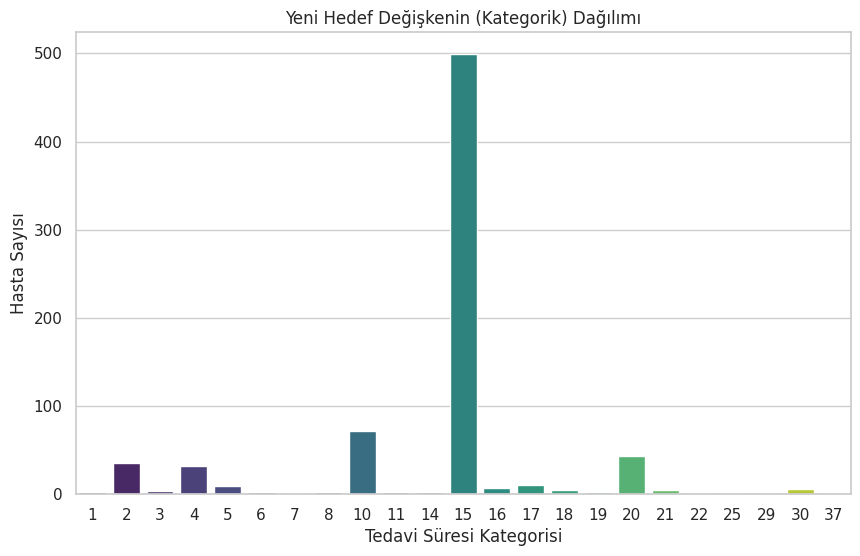

In [189]:
plt.figure(figsize=(10, 6))
sns.countplot(x='TedaviSuresi', data=df_processed, palette='viridis')
plt.title("Yeni Hedef Değişkenin (Kategorik) Dağılımı")
plt.xlabel("Tedavi Süresi Kategorisi")
plt.ylabel("Hasta Sayısı")
plt.show()

TedaviSuresi_Kategori
0_Cok_Kisa        90
1_Orta            77
2_Standart_15    499
3_Uzun            84
Name: count, dtype: int64


,TedaviSuresi,TedaviSuresi_Kategori,y_target_sinif
575,15,2_Standart_15,2
211,15,2_Standart_15,2
387,10,1_Orta,1
472,15,2_Standart_15,2
105,15,2_Standart_15,2
471,15,2_Standart_15,2
137,18,3_Uzun,3
483,15,2_Standart_15,2
745,15,2_Standart_15,2
542,10,1_Orta,1


/tmp/ipython-input-2249197305.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TedaviSuresi_Kategori', data=df_processed, order=labels, palette='viridis')


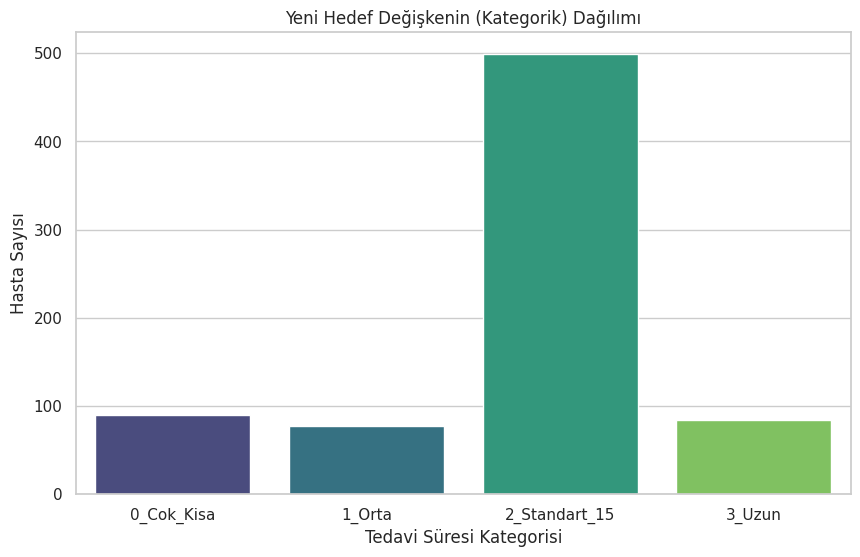

In [190]:
bins = [
    0,
    8,
    14,
    15,
    np.inf
]

labels = [
    '0_Cok_Kisa',
    '1_Orta',
    '2_Standart_15',
    '3_Uzun'
]

df_processed['TedaviSuresi_Kategori'] = pd.cut(df_processed['TedaviSuresi'],
                                              bins=bins,
                                              labels=labels,
                                              right=True)

df_processed['y_target_sinif'] = df_processed['TedaviSuresi_Kategori'].cat.codes

print(df_processed['TedaviSuresi_Kategori'].value_counts().sort_index())

display(df_processed[['TedaviSuresi', 'TedaviSuresi_Kategori', 'y_target_sinif']].sample(10))

# Yeni hedef değişkenimizin dağılımını görselleştirelim
plt.figure(figsize=(10, 6))
sns.countplot(x='TedaviSuresi_Kategori', data=df_processed, order=labels, palette='viridis')
plt.title("Yeni Hedef Değişkenin (Kategorik) Dağılımı")
plt.xlabel("Tedavi Süresi Kategorisi")
plt.ylabel("Hasta Sayısı")
plt.show()

## StandardScaler

In [191]:
from sklearn.preprocessing import StandardScaler

y_target = df_processed['y_target_sinif']
non_features = ['HastaNo', 'TedaviSuresi', 'y_target_sinif', 'KronikHastalik', 'Tanilar', 'UygulamaYerleri', 'TedaviAdi']
features_df = df_processed.drop(columns=[col for col in non_features if col in df_processed.columns])


# Ölçeklendirilecek sütunlar
cols_to_scale = [
    'Yas', 'UygulamaSuresi', 'KronikHastalik_Sayisi', 'Genel_Saglik_Skoru',
    'Tani_Sayisi', 'Yas_Karesi', 'UygulamaYerleri_cleaned_AdvFreq',
    'TedaviAdi_grouped_AdvFreq'
]
# Sadece df'te var olanları seç
cols_to_scale = [col for col in cols_to_scale if col in features_df.columns]


# Ölçeklendirilmeyecek (binary) sütunlar
cols_not_to_scale = [col for col in features_df.columns if col not in cols_to_scale]


scaler = StandardScaler()

scaled_data = scaler.fit_transform(features_df[cols_to_scale])

df_scaled = pd.DataFrame(scaled_data, columns=cols_to_scale)

print("Seçilen sütunlar başarıyla ölçeklendirildi.")

df_not_scaled = features_df[cols_not_to_scale].reset_index(drop=True)

# Ölçeklenmiş ve ölçeklenmemiş özellikleri birleş
X_final = pd.concat([df_scaled, df_not_scaled], axis=1)

display(X_final[cols_to_scale].describe().T)


Seçilen sütunlar başarıyla ölçeklendirildi.


,count,mean,std,min,25%,50%,75%,max
Yas,750.0,1.326346e-16,1.000667,-2.829777,-0.601281,-0.044157,0.636772,2.741462
UygulamaSuresi,750.0,2.818486e-16,1.000667,-2.185369,-0.281959,0.098724,0.669747,5.428273
KronikHastalik_Sayisi,750.0,-9.473903e-18,1.000667,-1.297377,-0.614068,0.069242,0.752552,1.435861
Genel_Saglik_Skoru,750.0,3.315866e-17,1.000667,-1.230880,-0.945072,-0.087648,0.769777,2.198817
Tani_Sayisi,750.0,4.026409e-17,1.000667,-1.399589,-0.881734,-0.363879,0.153976,5.332525
Yas_Karesi,750.0,1.894781e-17,1.000667,-1.587792,-0.685326,-0.205892,0.517961,3.714193


In [192]:
generate_comprehensive_report(df_processed)

rows x cols: (750, 46)
Total cells: 34500
Duplicated rows: 23
Column types:
HastaNo                                       int64
Yas                                           int64
TedaviSuresi                                  int64
UygulamaSuresi                                int64
Alerji_Alerji_Yok                             int64
Alerji_arveles                                int64
Alerji_coraspın                               int64
Alerji_gripin                                 int64
Alerji_novalgin                               int64
Alerji_polen                                  int64
Alerji_sucuk                                  int64
Alerji_toz                                    int64
Alerji_voltaren                               int64
Alerji_yer fıstığı                            int64
KanGrubu_0 rh+                                int64
KanGrubu_Bilinmiyor                           int64
KanGrubu_a rh+                                int64
KanGrubu_ab rh+                         

In [193]:
import pandas as pd
import numpy as np

final_df = X_final.copy()


print("--- Nihai DataFrame'i Yeniden Sıralama ve İsimlendirme ---")

demografik_ozellikler = [
    'Yas',
    'Yas_Karesi',
    'Cinsiyet_Erkek',
    'YasGrubu_0_Bebek (2-4)',
    'YasGrubu_1_Cocuk (5-11)',
    'YasGrubu_2_Ergen (12-17)',
    'YasGrubu_3_Genc_Yetiskin (18-39)',
    'YasGrubu_4_Orta_Yas (40-64)',
    'YasGrubu_5_Yasli (65+)'
]

tibbi_gecmis_ozellikleri = [
    'Genel_Saglik_Skoru',
    'KronikHastalik_Sayisi',
    'KanGrubu_Bilinmiyor',
    'KanGrubu_0 rh+',
    'KanGrubu_a rh+',
    'KanGrubu_b rh+',
    'KanGrubu_ab rh+',
    'KanGrubu_b rh-',
]

alerji_ozellikleri = [
    'Coklu_Ilac_Alerjisi_Sayisi',
    'Alerji_Alerji_Yok',
    'Alerji_polen',
    'Alerji_toz',
    'Alerji_novalgin',
    'Alerji_sucuk',
    'Alerji_voltaren',
    'Alerji_arveles',
    'Alerji_coraspın',
    'Alerji_gripin',
    'Alerji_yer fıstığı'
]

tani_ve_tedavi_ozellikleri = [
    'UygulamaSuresi',
    'Bolum_Is_FizikselTip',
    'Bolum_Is_Ortopedi',
    'Tani_Sayisi',
    'Tani_Ciddiyeti_Yuksek',
    'Ortopedi_ve_Ciddi_Tani',
    'OdakBolgesi_Govde',
    'OdakBolgesi_Ust_Ekstremite',
    'OdakBolgesi_Alt_Ekstremite',
    'OdakBolgesi_Diger_Bolge',
    'TedaviAdi_grouped_AdvFreq',
    'UygulamaYerleri_cleaned_AdvFreq'
]

tum_sutunlar = demografik_ozellikler + tibbi_gecmis_ozellikleri + alerji_ozellikleri + tani_ve_tedavi_ozellikleri
mevcut_sutunlar = [col for col in tum_sutunlar if col in final_df.columns]

final_df = final_df[mevcut_sutunlar]

print("Adım 1: Sütunlar mantıksal gruplara göre başarıyla yeniden sıralandı.")

rename_dict = {
    'TedaviSuresi': 'TedaviSuresi (seans)',
    'UygulamaSuresi': 'UygulamaSuresi (dakika)'
}

if 'UygulamaSuresi' in final_df.columns:
    final_df.rename(columns={'UygulamaSuresi': 'UygulamaSuresi (dakika)'}, inplace=True)
    print("Adım 2: 'UygulamaSuresi' sütunu 'UygulamaSuresi (dakika)' olarak yeniden adlandırıldı.")
else:
    print("Adım 2: 'UygulamaSuresi' sütunu bulunamadığı için yeniden adlandırma yapılmadı.")

display(final_df.head())

--- Nihai DataFrame'i Yeniden Sıralama ve İsimlendirme ---
Adım 1: Sütunlar mantıksal gruplara göre başarıyla yeniden sıralandı.
Adım 2: 'UygulamaSuresi' sütunu 'UygulamaSuresi (dakika)' olarak yeniden adlandırıldı.


,Yas,Yas_Karesi,Cinsiyet_Erkek,YasGrubu_0_Bebek (2-4),YasGrubu_1_Cocuk (5-11),YasGrubu_2_Ergen (12-17),YasGrubu_3_Genc_Yetiskin (18-39),YasGrubu_4_Orta_Yas (40-64),YasGrubu_5_Yasli (65+),Genel_Saglik_Skoru,...,UygulamaSuresi (dakika),Bolum_Is_FizikselTip,Bolum_Is_Ortopedi,Tani_Sayisi,Tani_Ciddiyeti_Yuksek,Ortopedi_ve_Ciddi_Tani,OdakBolgesi_Govde,OdakBolgesi_Ust_Ekstremite,OdakBolgesi_Alt_Ekstremite,OdakBolgesi_Diger_Bolge
0,0.760577,0.665865,0,0,0,0,0,1,0,0.769777,...,0.669747,1,0,-0.881734,1,0,0,0,1,0
1,-1.220308,-1.098957,1,0,0,0,1,0,0,1.913009,...,-0.281959,1,0,0.671830,1,0,1,0,0,0
2,-1.220308,-1.098957,1,0,0,0,1,0,0,1.913009,...,0.669747,1,0,0.671830,1,0,1,0,0,0
3,0.760577,0.665865,1,0,0,0,0,1,0,-1.230880,...,1.240770,1,0,-0.881734,1,0,0,1,0,0
4,1.070091,1.057560,0,0,0,0,0,1,0,1.341393,...,-0.281959,1,0,0.153976,0,0,0,1,0,0


In [194]:
final_df.to_excel('Talent_final_bitmis_data.xlsx', index=False)
y_target.to_excel('y_target_bitmis_hedef_datası.xlsx', index=False)

# Test

In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_excel('Talent_final_bitmis_data.xlsx')
y = pd.read_excel('y_target_bitmis_hedef_datası.xlsx').iloc[:, 0]

# 2. %80 train, %20 test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.to_excel('X_train.xlsx', index=False)
X_test.to_excel('X_test.xlsx', index=False)
y_train.to_excel('y_train.xlsx', index=False, header=True)
y_test.to_excel('y_test.xlsx', index=False, header=True)


In [196]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Kullanılan Cihaz: {device}")

X_train_df = pd.read_excel('X_train.xlsx')
X_test_df = pd.read_excel('X_test.xlsx')
y_train_df = pd.read_excel('y_train.xlsx')
y_test_df = pd.read_excel('y_test.xlsx')

# DataFrame'leri NumPy array'lerine çeviriyoruz
X_train_np = X_train_df.values
X_test_np = X_test_df.values
y_train_np = y_train_df.values.flatten()
y_test_np = y_test_df.values.flatten()

# NumPy array'lerini PyTorch tensor'larına dönüştürüyoruz
# Özellikler float, etiketler long (integer) olmalıdır.
X_train = torch.from_numpy(X_train_np).float()
X_test = torch.from_numpy(X_test_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_test = torch.from_numpy(y_test_np).long()

if X_train is not None:
    INPUT_FEATURES = X_train.shape[1]
    OUTPUT_FEATURES = len(torch.unique(y_train))
    HIDDEN_UNITS = 128

    model = nn.Sequential(
        nn.Linear(in_features=INPUT_FEATURES, out_features=HIDDEN_UNITS),
        nn.ReLU(),
        nn.Linear(in_features=HIDDEN_UNITS, out_features=HIDDEN_UNITS // 2),
        nn.ReLU(),
        nn.Linear(in_features=HIDDEN_UNITS // 2, out_features=OUTPUT_FEATURES)
    ).to(device)

    print("\nModel Mimarisi:")
    print(model)

    # Çok sınıflı sınıflandırma için CrossEntropyLoss
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    epochs = 450

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    print("\nEğitim döngüsü başlatılıyor...")
    for epoch in range(epochs):
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)

        # 2. Loss hesaplama
        loss = loss_fn(y_logits, y_train)

        # 3. Optimizer'ın gradyanlarını sıfırlama
        optimizer.zero_grad()

        # 4. Geriye yayılım (Backpropagation)
        loss.backward()

        # 5. Ağırlıkları güncelleme
        optimizer.step()

        # Değerlendirme
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)

        # Her 20 epoch'ta bir durumu yazdır
        if epoch % 25 == 0:
            # Doğruluk hesaplama
            y_pred_class = torch.softmax(y_logits, dim=1).argmax(dim=1)
            train_acc = (y_pred_class == y_train).sum().item() / len(y_train) * 100

            test_pred_class = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc = (test_pred_class == y_test).sum().item() / len(y_test) * 100

            print(f"Epoch: {epoch:4d} | Train Loss: {loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    print("\n--- Final Model Performans Değerlendirmesi ---")
    model.eval()
    with torch.inference_mode():
        # Test seti üzerinde nihai tahminleri yap
        y_preds_logits = model(X_test)
        # Logitleri sınıflara çevir (0, 1, 2, 3)
        y_preds = torch.softmax(y_preds_logits, dim=1).argmax(dim=1)

    # Tensor'ları CPU'ya geri alıp NumPy'e çevirerek scikit-learn raporlarını kullanabiliriz.
    y_preds_np = y_preds.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Sınıf etiketleri
    class_labels = ['0_Cok_Kisa', '1_Orta', '2_Standart_15', '3_Uzun']

    print("\nSINIFLANDIRMA RAPORU:")
    print(classification_report(y_test_np, y_preds_np, target_names=class_labels))

Kullanılan Cihaz: cuda

Model Mimarisi:
Sequential(
  (0): Linear(in_features=37, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=4, bias=True)
)

Eğitim döngüsü başlatılıyor...
Epoch:    0 | Train Loss: 1.38395, Train Acc: 29.83% | Test Loss: 1.36322, Test Acc: 39.33%
Epoch:   25 | Train Loss: 0.94343, Train Acc: 66.50% | Test Loss: 0.94083, Test Acc: 66.67%
Epoch:   50 | Train Loss: 0.75311, Train Acc: 76.67% | Test Loss: 0.78370, Test Acc: 77.33%
Epoch:   75 | Train Loss: 0.60448, Train Acc: 79.00% | Test Loss: 0.67226, Test Acc: 78.67%
Epoch:  100 | Train Loss: 0.51033, Train Acc: 81.83% | Test Loss: 0.63642, Test Acc: 78.67%
Epoch:  125 | Train Loss: 0.41619, Train Acc: 86.00% | Test Loss: 0.62887, Test Acc: 78.00%
Epoch:  150 | Train Loss: 0.32234, Train Acc: 89.33% | Test Loss: 0.63342, Test Acc: 79.33%
Epoch:  175 | Train Loss: 0.23377, Train Acc: 92.83% | Test Loss: 0